In [1]:
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import gc
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import statsmodels.api as sm
!pip install catboost
import os
import pickle
import requests
from zipfile import ZipFile
from tqdm import tqdm
import warnings
from scipy.stats import mstats
from scipy import stats
warnings.filterwarnings("ignore")
import json
import pickle
import seaborn as sns
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.5 MB/s eta 0:00:00


In [ ]:
black = '\033[30m'
red = '\033[31m'
green = '\033[32m'
yellow = '\033[33m'
blue = '\033[34m'
magenta = '\033[35m'
cyan = '\033[36m'
white = '\033[37m'
orange = "\033[38;5;208m"
bold = '\033[1m'
reset = '\033[0m'


In [3]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/Florida-Coral-Reef'
os.chdir(folder_path)


Mounted at /content/drive


In [ ]:
# scor = pd.read_csv('encoded_missed_new_feature_scor.csv')
scor = pd.read_csv('scor_minimal.csv')
scor.shape

(1241926, 277)

In [ ]:
# taxaGropup_Density = pd.read_csv('dataset/CREMP_Pcover_2023_TaxaGroups.csv')
# taxaGropup_Density.columns
# scor = scor.merge(taxaGropup_Density[['Year', 'StationID', 'Stony_coral']], on=['Year', 'StationID'], how ='left')
# Pcover_cols = [col for col in scor.columns if 'pcover' in col.lower() and col not in ['Pcover_StonyCoralSpecies_points'] ]
# scor['Pcover_Total_stonyCoral'] = scor[Pcover_cols].sum(axis=1)
# scor['Pcover_Total'] = scor['Pcover_Total_stonyCoral'] + scor['Stony_coral']
# scor.columns

Index(['Year', 'SiteID', 'StationID', 'SCOR_RawData_SPP_CODE',
       'SCOR_RawData_sciName', 'SCOR_RawData_Diameter_cm',
       'SCOR_RawData_Height_cm', 'SCOR_RawData_Percent_old_mortality',
       'SCOR_RawData_Percent_recent_mortality', 'SCOR_RawData_Tissue_isolates',
       ...
       'healthy', 'Season', 'Date', 'TimeIndex', 'Density_Diversity',
       'Density_Evenness', 'Health_Score', 'Stony_coral',
       'Pcover_Total_stonyCoral', 'Pcover_Total'],
      dtype='object', length=280)

In [ ]:
# targets = ['Total_Mortality_Percent', 'Species_Richness','SCOR_RawData_LTA_cm2','Total_Density', 'Health_Score']
# env_predictors = ['TempC', 'Stations_Depth_ft']
# physical_predictors = ['SCOR_RawData_Diameter_cm', 'SCOR_RawData_Height_cm']
# condition_predictors = [col for col in scor.columns if col.startswith('SCOR_ConditionCounts_')
#                         and col not in ['SCOR_ConditionCounts_sciName', 'SCOR_ConditionCounts_Count']]
# Pcover_predictors = [col for col in scor.columns if 'pcover' in col.lower() and col not in ['Pcover_StonyCoralSpecies_OID_','Pcover_StonyCoralSpecies_Surveyed_all_years',] ]
# features = ['TempC' , 'healthy', 'Date', 'Month', 'Year', 'StationID', 'SiteID'] +targets +  env_predictors + physical_predictors + condition_predictors +Pcover_predictors
# scor[features].to_csv('scor_minimal.csv', index=False)

In [ ]:
octo = pd.read_csv('merged_octo.csv')
octo.shape


(108203, 50)

In [ ]:
octo.columns

Index(['Year', 'SiteID', 'StationID', 'OCTO_RawData_SPP_Code',
       'OCTO_RawData_sciName', 'OCTO_RawData_Height_cm', 'Month',
       'OCTO_Density_Eunicea_calyculata', 'OCTO_Density_Gorgonia_ventalina',
       'OCTO_Density_Pseudopterogorgia_americana',
       'OCTO_Density_Pseudopterogorgia_bipinnata',
       'OCTO_Density_Eunicea_flexuosa', 'OCTO_Density_Pseudoplexaura_porosa',
       'OCTO_Density_Total_Octocorals', 'Date', 'Subregion', 'Habitat',
       'Site_name_x', 'OCTO_MeanHeight_Eunicea_calyculata',
       'OCTO_MeanHeight_Gorgonia_ventalina',
       'OCTO_MeanHeight_Pseudopterogorgia_americana',
       'OCTO_MeanHeight_Pseudopterogorgia_bipinnata',
       'OCTO_MeanHeight_Eunicea_flexuosa',
       'OCTO_MeanHeight_Pseudoplexaura_porosa',
       'Pcover_TaxaGroups_Surveyed_all_years', 'Pcover_TaxaGroups_points',
       'Pcover_TaxaGroups_Cyanobacteria', 'Pcover_TaxaGroups_Macroalgae',
       'Pcover_TaxaGroups_Octocoral', 'Pcover_TaxaGroups_Others',
       'Pcover_TaxaGrou

### Identify key factors affecting coral health, density, and species richness. (5)


In [ ]:
# Calculate total mortality
if 'SCOR_RawData_Percent_old_mortality' in scor.columns and 'SCOR_RawData_Percent_recent_mortality' in scor.columns:
    scor['Total_Mortality_Percent'] = (scor['SCOR_RawData_Percent_old_mortality'] +
                                          scor['SCOR_RawData_Percent_recent_mortality'])

# Calculate species richness per site and year
species_richness = scor.groupby(['StationID', 'Year'])['SCOR_RawData_sciName'].nunique().reset_index()
species_richness.rename(columns={'SCOR_RawData_sciName': 'Species_Richness'}, inplace=True)
scor = scor.merge(species_richness, on=['StationID', 'Year'], how='left')


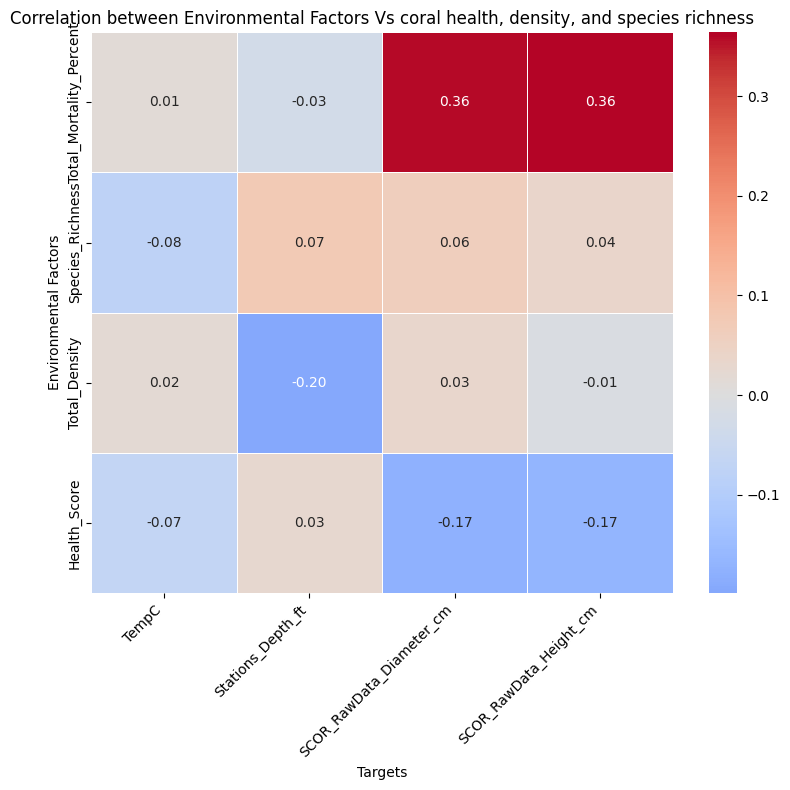

In [ ]:
env_vars = ['TempC', 'Stations_Depth_ft' , 'SCOR_RawData_Diameter_cm', 'SCOR_RawData_Height_cm']
metrics = ['Total_Mortality_Percent', 'Species_Richness', 'Total_Density' , 'Health_Score']

    # Create correlation matrix
corr_matrix = scor[env_vars].apply(
    lambda col: scor[metrics].corrwith(col)
)
plt.figure(figsize=(8, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt='.2f',
    linewidths=0.5
)
plt.title('Correlation between Environmental Factors Vs coral health, density, and species richness')
plt.xlabel('Targets')
plt.ylabel('Environmental Factors')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

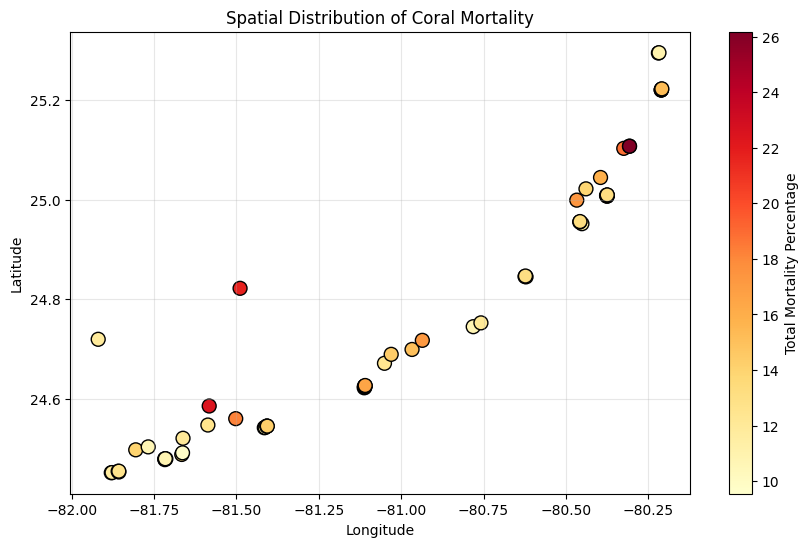

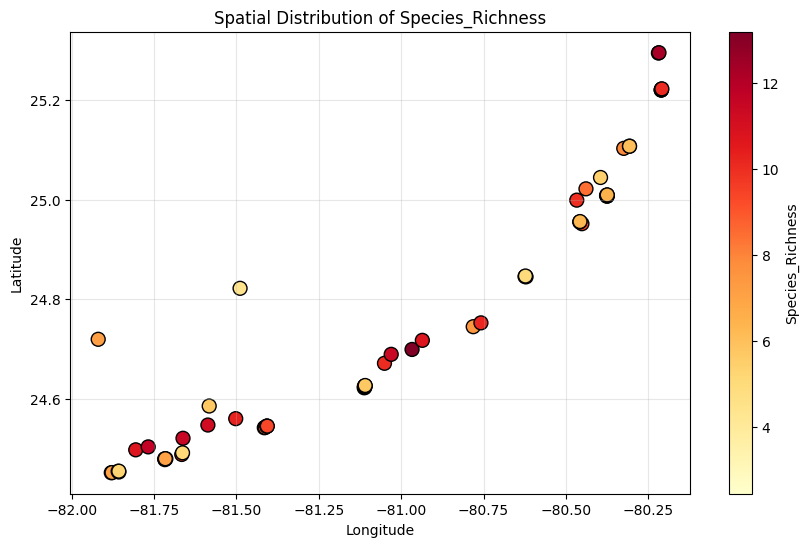

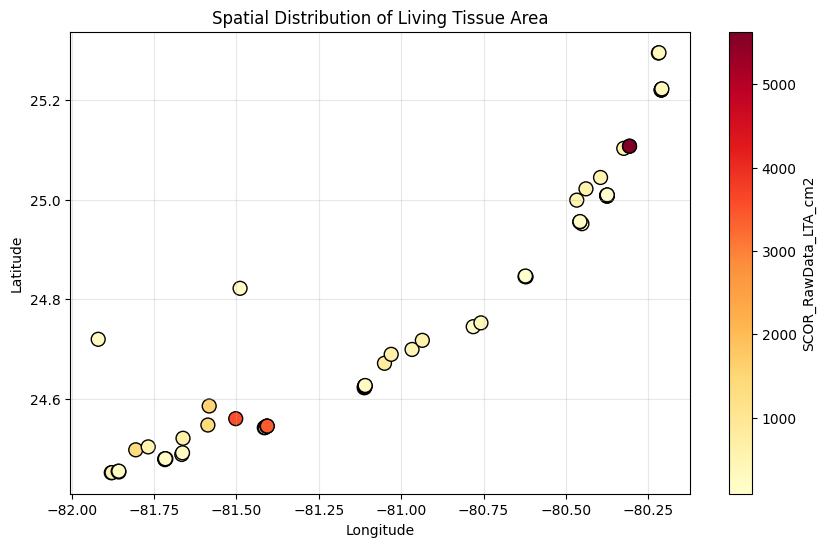

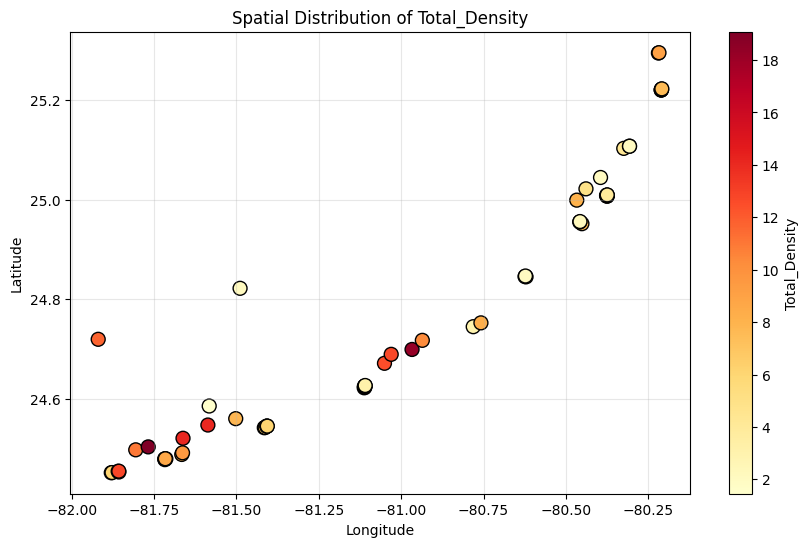

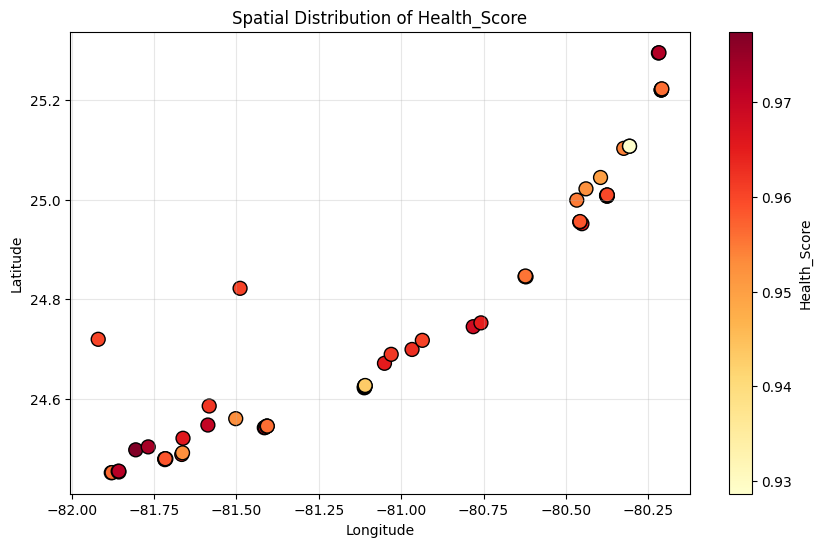

In [ ]:
def analyze_spatial_patterns(df):
    # Calculate site-level averages
    site_metrics = df.groupby(['Stations_latDD', 'Stations_lonDD']).agg({
        'Species_Richness': 'mean',
        'Total_Mortality_Percent': 'mean',
        'SCOR_RawData_LTA_cm2': 'mean',
        'Total_Density': 'mean',
        'Health_Score' : 'mean'
    }).reset_index()

    # -----------------Plot spatial distribution of mortality-------------
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        site_metrics['Stations_lonDD'],
        site_metrics['Stations_latDD'],
        c=site_metrics['Total_Mortality_Percent'],
        cmap='YlOrRd',
        s=100,
        edgecolor='k'
    )
    plt.colorbar(scatter, label='Total Mortality Percentage')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Spatial Distribution of Coral Mortality')
    plt.grid(True, alpha=0.3)

    # ---------------Species_Richness -Spaial --------------------
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        site_metrics['Stations_lonDD'],
        site_metrics['Stations_latDD'],
        c=site_metrics['Species_Richness'],
        cmap='YlOrRd',
        s=100,
        edgecolor='k'
    )
    plt.colorbar(scatter, label='Species_Richness')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Spatial Distribution of Species_Richness')
    plt.grid(True, alpha=0.3)

       # ---------------Living Tissue Area - Spaial --------------------
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        site_metrics['Stations_lonDD'],
        site_metrics['Stations_latDD'],
        c=site_metrics['SCOR_RawData_LTA_cm2'],
        cmap='YlOrRd',
        s=100,
        edgecolor='k'
    )
    plt.colorbar(scatter, label='SCOR_RawData_LTA_cm2')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Spatial Distribution of Living Tissue Area')
    plt.grid(True, alpha=0.3)
    # ---------------Total_Density - Spaial --------------------
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        site_metrics['Stations_lonDD'],
        site_metrics['Stations_latDD'],
        c=site_metrics['Total_Density'],
        cmap='YlOrRd',
        s=100,
        edgecolor='k'
    )
    plt.colorbar(scatter, label='Total_Density')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Spatial Distribution of Total_Density')
    plt.grid(True, alpha=0.3)
    # ---------------Health_Score - Spaial --------------------
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        site_metrics['Stations_lonDD'],
        site_metrics['Stations_latDD'],
        c=site_metrics['Health_Score'],
        cmap='YlOrRd',
        s=100,
        edgecolor='k'
    )
    plt.colorbar(scatter, label='Health_Score')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Spatial Distribution of Health_Score')
    plt.grid(True, alpha=0.3)
analyze_spatial_patterns(scor)


In [ ]:
def analyze_colony_characteristics(df):
    # Relationship between colony size and health
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Features and target
    X = df[['SCOR_RawData_Diameter_cm', 'SCOR_RawData_Height_cm']]
    y = df['Total_Mortality_Percent']

    # Split data and train model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model.fit(X_train, y_train)

    # Feature importance
    importances = model.feature_importances_
    feature_names = X.columns
    for name, importance in zip(feature_names, importances):
        print(f"{name}: {importance:.4f}")
analyze_colony_characteristics(scor)

SCOR_RawData_Diameter_cm: 0.1917
SCOR_RawData_Height_cm: 0.8083


In [ ]:
def analyze_condition_prevalence(df):
    condition_cols = [col for col in df.columns if col.startswith('SCOR_ConditionCounts_')
                     and col not in ['SCOR_ConditionCounts_sciName', 'SCOR_ConditionCounts_Count']]

    # Sum conditions across observations
    condition_sums = df[condition_cols].sum().sort_values(ascending=False)

    # Create condition presence indicator
    df['Has_Condition'] = (df[condition_cols].sum(axis=1) > 0).astype(int)

    # Compare mortality between colonies with and without conditions
    condition_mortality = df.groupby('Has_Condition')['Total_Mortality_Percent'].mean()
    print("Average mortality percentage:")
    print(f"Colonies without conditions: {condition_mortality[0]:.2f}%")
    print(f"Colonies with conditions: {condition_mortality[1]:.2f}%")
analyze_condition_prevalence(scor)

Average mortality percentage:
Colonies without conditions: 12.87%
Colonies with conditions: 14.00%


In [ ]:
def build_integrated_model(df):
    # Potential predictors
    env_predictors = ['TempC', 'Stations_Depth_ft']
    physical_predictors = ['SCOR_RawData_Diameter_cm', 'SCOR_RawData_Height_cm']
    condition_predictors = [col for col in df.columns if col.startswith('SCOR_ConditionCounts_')
                           and col not in ['SCOR_ConditionCounts_sciName', 'SCOR_ConditionCounts_Count']]

    # Combine all predictors
    all_predictors = env_predictors + physical_predictors + condition_predictors

    # Target variables to predict
    target_vars = ['Total_Mortality_Percent', 'Species_Richness',
                   'SCOR_RawData_LTA_cm2','Total_Density', 'Health_Score']

    for target in target_vars:
        # Prepare data
        X = df[all_predictors].copy()
        y = df[target].copy()

        # Handle missing values
        X = X.fillna(X.median())
        valid_rows = ~y.isna()
        X = X.loc[valid_rows]
        y = y.loc[valid_rows]

        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Train model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)

        # Evaluate
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"R² for {target}: {r2:.4f}")
        print(f"mse for {target}: {mse:.4f}")
        print(f"rmse for {target}: {rmse:.4f}")

        # Feature importance
        feature_importances = pd.DataFrame({
            'Feature': all_predictors,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)

        print(f"Top 5 predictors for {target}:")
        print(feature_importances.head(5))
build_integrated_model(scor)

R² for Total_Mortality_Percent: 0.6966
mse for Total_Mortality_Percent: 147.2330
rmse for Total_Mortality_Percent: 12.1340
Top 5 predictors for Total_Mortality_Percent:
                    Feature  Importance
3    SCOR_RawData_Height_cm    0.317371
0                     TempC    0.246020
2  SCOR_RawData_Diameter_cm    0.233116
1         Stations_Depth_ft    0.140775
6  SCOR_ConditionCounts_PAL    0.021443
R² for Species_Richness: 0.9410
mse for Species_Richness: 0.5245
rmse for Species_Richness: 0.7242
Top 5 predictors for Species_Richness:
                    Feature  Importance
0                     TempC    0.499563
1         Stations_Depth_ft    0.400089
2  SCOR_RawData_Diameter_cm    0.029559
3    SCOR_RawData_Height_cm    0.021612
6  SCOR_ConditionCounts_PAL    0.018066
R² for SCOR_RawData_LTA_cm2: 0.9987
mse for SCOR_RawData_LTA_cm2: 15123.2108
rmse for SCOR_RawData_LTA_cm2: 122.9765
Top 5 predictors for SCOR_RawData_LTA_cm2:
                    Feature  Importance
2  SCOR_RawDa

In [ ]:
targets = ['Total_Mortality_Percent', 'Species_Richness','SCOR_RawData_LTA_cm2','Total_Density', 'Health_Score']
env_predictors = ['TempC', 'Stations_Depth_ft']
physical_predictors = ['SCOR_RawData_Diameter_cm', 'SCOR_RawData_Height_cm']
condition_predictors = [col for col in scor.columns if col.startswith('SCOR_ConditionCounts_')
                        and col not in ['SCOR_ConditionCounts_sciName', 'SCOR_ConditionCounts_Count']]
features = ['TempC', 'Total_Mortality_Percent', 'SCOR_RawData_LTA_cm2', 'Health_Score' , 'healthy'] +targets +  env_predictors + physical_predictors + condition_predictors
for target in targets:
  correlations = scor[features].corr()[target]
  selected_cols = correlations[abs(correlations) > 0.3].index.tolist()
  print(target, ': ', selected_cols)



Total_Mortality_Percent :  ['TempC', 'Total_Mortality_Percent', 'SCOR_RawData_LTA_cm2', 'Health_Score', 'healthy', 'Total_Mortality_Percent', 'Species_Richness', 'SCOR_RawData_LTA_cm2', 'Total_Density', 'Health_Score', 'TempC', 'Stations_Depth_ft', 'SCOR_RawData_Diameter_cm', 'SCOR_RawData_Height_cm', 'SCOR_ConditionCounts_BLH', 'SCOR_ConditionCounts_PBL', 'SCOR_ConditionCounts_PAL', 'SCOR_ConditionCounts_BBD', 'SCOR_ConditionCounts_WBD', 'SCOR_ConditionCounts_WPX', 'SCOR_ConditionCounts_WPL', 'SCOR_ConditionCounts_DSD', 'SCOR_ConditionCounts_SCT', 'SCOR_ConditionCounts_RTL', 'SCOR_ConditionCounts_RBD', 'SCOR_ConditionCounts_YBD', 'SCOR_ConditionCounts_UNK']
Species_Richness :  ['Species_Richness', 'Total_Density']
SCOR_RawData_LTA_cm2 :  ['TempC', 'Total_Mortality_Percent', 'SCOR_RawData_LTA_cm2', 'Health_Score', 'healthy', 'Total_Mortality_Percent', 'Species_Richness', 'SCOR_RawData_LTA_cm2', 'Total_Density', 'Health_Score', 'TempC', 'Stations_Depth_ft', 'SCOR_RawData_Diameter_cm', '

### Identify early indicators that could help anticipate significant declines in stony or octocoral populations. (5)


In [ ]:
station = scor['StationID'].unique()
features =
for st in station:
  df = scor[scor['StationID'] == st]
  # print(st, ': ', len(df), len(df.drop_duplicates(subset=['Date'], keep='first', inplace=False)), df['Date'].unique())
  for lag in [1, 2]:
    for col in ['TempC', 'Stations_Depth_ft', 'SCOR_RawData_LTA_cm2', 'Health_Score' , 'Total_Density' , 'Total_Mortality_Percent',  'Pcover_Total']:
        df[f"{col}_lag{lag}"] = df[col].shift(lag)



In [ ]:
from sklearn.linear_model import Ridge

def identify_early_indicators(df):
    # Aggregate data by year
    yearly_data = df.groupby('Year').agg({
        'TempC': 'mean',
        'Stations_Depth_ft': 'mean',
        'Total_Mortality_Percent': 'mean',
        'Species_Richness': 'mean',
        'Total_Density': 'mean',
        'Health_Score' : 'mean',
        'Pcover_Total': 'mean',
        'healthy': 'mean',
        'SCOR_RawData_LTA_cm2': 'mean'  # Live Tissue Area
    }).reset_index()

    # Create lagged variables (t-1, t-2)
    for lag in [1, 2]:
        for col in ['TempC', 'Stations_Depth_ft', 'SCOR_RawData_LTA_cm2', 'Health_Score' , 'Total_Density' , 'Total_Mortality_Percent',  'Pcover_Total']:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)

    # Drop rows with NaN from lagging
    lagged_data = df.dropna()
    for target in ['Total_Mortality_Percent', 'Species_Richness','Total_Density', 'Pcover_Total']:
      # Build regression model to predict species richness
      X = lagged_data[[col for col in lagged_data.columns if '_lag' in col]]
      y = lagged_data[target]
      # model = Ridge(alpha=1.0)
      # model.fit(X, y)
      model = sm.OLS(y, sm.add_constant(X)).fit()
      print(f'{bold}{yellow}{target}{reset}')

      print(model.summary())
identify_early_indicators(scor)

Total_Mortality_Percent
                               OLS Regression Results                              
Dep. Variable:     Total_Mortality_Percent   R-squared:                       0.813
Model:                                 OLS   Adj. R-squared:                  0.813
Method:                      Least Squares   F-statistic:                 3.850e+05
Date:                     Tue, 22 Apr 2025   Prob (F-statistic):               0.00
Time:                             17:27:47   Log-Likelihood:            -4.5660e+06
No. Observations:                  1241924   AIC:                         9.132e+06
Df Residuals:                      1241909   BIC:                         9.132e+06
Df Model:                               14                                         
Covariance Type:                 nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [ ]:
import xgboost as xgb

def build_integrated_model(df):
    # Potential predictors
    env_predictors = ['TempC', 'Stations_Depth_ft']
    physical_predictors = ['SCOR_RawData_Diameter_cm', 'SCOR_RawData_Height_cm']
    condition_predictors = [col for col in df.columns if col.startswith('SCOR_ConditionCounts_')
                           and col not in ['SCOR_ConditionCounts_sciName', 'SCOR_ConditionCounts_Count']]

    for lag in [1, 2]:
      for col in ['TempC', 'Stations_Depth_ft', 'SCOR_RawData_LTA_cm2', 'Health_Score' , 'Total_Density' , 'Total_Mortality_Percent',  'Pcover_Total']:
          df[f"{col}_lag{lag}"] = df[col].shift(lag)


    # Target variables to predict
    target_vars = ['Total_Mortality_Percent', 'Species_Richness',
                   'SCOR_RawData_LTA_cm2','Total_Density', 'Health_Score', 'Pcover_Total']

    for target in target_vars:
        print(f'{bold}{yellow}{target}{reset}')
        # Prepare data
        all_predictors = [col for col in df.columns if '_lag' in col]
        X = df[all_predictors].copy()
        y = df[target].copy()

        # Handle missing values
        X = X.fillna(X.median())
        valid_rows = ~y.isna()
        X = X.loc[valid_rows]
        y = y.loc[valid_rows]
        print(X.shape, y.shape)

        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Train model
        model = xgb.XGBRegressor(n_estimators=100, random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)

        # Evaluate
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"R² for {target}: {r2:.4f}")
        print(f"mse for {target}: {mse:.4f}")
        print(f"rmse for {target}: {rmse:.4f}")

        # Feature importance
        feature_importances = pd.DataFrame({
            'Feature': all_predictors,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)

        print(f"Top 7 predictors for {target}:")
        print(feature_importances.head(7))
build_integrated_model(scor)

Total_Mortality_Percent
(1241926, 14) (1241926,)
R² for Total_Mortality_Percent: 0.8097
mse for Total_Mortality_Percent: 92.3622
rmse for Total_Mortality_Percent: 9.6105
Top 7 predictors for Total_Mortality_Percent:
                         Feature  Importance
5   Total_Mortality_Percent_lag1    0.988182
12  Total_Mortality_Percent_lag2    0.002144
8         Stations_Depth_ft_lag2    0.001424
1         Stations_Depth_ft_lag1    0.001245
13             Pcover_Total_lag2    0.001158
6              Pcover_Total_lag1    0.000934
4             Total_Density_lag1    0.000892
Species_Richness
(1241926, 14) (1241926,)
R² for Species_Richness: 0.9786
mse for Species_Richness: 0.1902
rmse for Species_Richness: 0.4361
Top 7 predictors for Species_Richness:
                   Feature  Importance
6        Pcover_Total_lag1    0.278901
4       Total_Density_lag1    0.191987
1   Stations_Depth_ft_lag1    0.166570
0               TempC_lag1    0.103603
7               TempC_lag2    0.078938
8   Statio

In [ ]:
def identify_environmental_thresholds(df):
    # Test different temperature thresholds
    thresholds = np.linspace(df['TempC'].min(), df['TempC'].max(), 20)
    threshold_mortality = []

    for threshold in thresholds:
        # Group data by whether temp exceeds threshold
        above_threshold = df['TempC'] > threshold
        mortality_by_group = df.groupby(above_threshold)['Total_Mortality_Percent'].mean()

        if len(mortality_by_group) == 2:
            mortality_difference = mortality_by_group[True] - mortality_by_group[False]
            threshold_mortality.append((threshold, mortality_difference))

    # Find threshold with maximum difference
    threshold_mortality.sort(key=lambda x: x[1], reverse=True)
    optimal_threshold = threshold_mortality[0][0]

    print(f"Optimal temperature threshold: {optimal_threshold:.2f}°C")
    print(f"Average mortality below threshold: {df[df['TempC'] <= optimal_threshold]['Total_Mortality_Percent'].mean():.2f}%")
    print(f"Average mortality above threshold: {df[df['TempC'] > optimal_threshold]['Total_Mortality_Percent'].mean():.2f}%")
identify_environmental_thresholds(scor)

Optimal temperature threshold: 26.63°C
Average mortality below threshold: 10.52%
Average mortality above threshold: 13.38%


In [ ]:
def build_early_warning_system(df):
    # Feature engineering for early warning indicators
    df['High_Temp_Risk'] = (df['TempC'] > 29.8).astype(int)
    df['Bleaching_Present'] = (df['SCOR_ConditionCounts_BLH'] > 0).astype(int)
    df['TissueLoss_Present'] = (df['SCOR_ConditionCounts_RTL'] > 0).astype(int)
    df['Small_Colony'] = (df['SCOR_RawData_Diameter_cm'] < df['SCOR_RawData_Diameter_cm'].median()).astype(int)

    # Create composite risk score (0-4)
    df['Decline_Risk_Score'] = (df['High_Temp_Risk'] + df['Bleaching_Present'] +
                               df['TissueLoss_Present'] + df['Small_Colony'])

    # Evaluate risk score as predictor of future mortality
    risk_mortality = df.groupby('Decline_Risk_Score')['Total_Mortality_Percent'].mean()

    for risk_level, mortality in risk_mortality.items():
        print(f"Risk score {risk_level}: Average mortality {mortality:.2f}%")

    # Calculate correlation between risk score and mortality
    risk_mortality_corr = df['Decline_Risk_Score'].corr(df['Total_Mortality_Percent'])
    print(f"Correlation between risk score and mortality: {risk_mortality_corr:.4f}")
build_early_warning_system(scor)

Risk score 0: Average mortality 18.64%
Risk score 1: Average mortality 12.40%
Risk score 2: Average mortality 7.53%
Risk score 3: Average mortality 6.54%
Correlation between risk score and mortality: -0.1786


## Model the evolution of coral reefs at the observed stations over the next five years based on trends identified in the datasets. (30)

### Stony Coral

#### Missed and Encoding

In [ ]:
missed = pd.DataFrame({
    'column_name': scor.columns,
    'number_of_missing_values': scor.isnull().sum(),
    'percentage_of_missing_values': (scor.isnull().sum() / len(scor)) * 100
})
missed[missed["percentage_of_missing_values"] > 0]


,column_name,number_of_missing_values,percentage_of_missing_values
SCOR_RawData_Percent_old_mortality,SCOR_RawData_Percent_old_mortality,421,0.033899
SCOR_RawData_Percent_recent_mortality,SCOR_RawData_Percent_recent_mortality,356,0.028665
SCOR_RawData_Tissue_isolates,SCOR_RawData_Tissue_isolates,13789,1.110292
SCOR_RawData_Conditions,SCOR_RawData_Conditions,908950,73.188741
SCOR_RawData_LTA_cm2,SCOR_RawData_LTA_cm2,421,0.033899
SCOR_Counts_Orbicella_faveolata,SCOR_Counts_Orbicella_faveolata,197147,15.874295
SCOR_Counts_Orbicella_franksi,SCOR_Counts_Orbicella_franksi,197147,15.874295
SCOR_Density_Orbicella_faveolata,SCOR_Density_Orbicella_faveolata,196067,15.787334
SCOR_Density_Orbicella_franksi,SCOR_Density_Orbicella_franksi,196067,15.787334
SCOR_LTA_Orbicella_faveolata,SCOR_LTA_Orbicella_faveolata,197147,15.874295


In [ ]:
scor['SCOR_RawData_Conditions'] = scor['SCOR_RawData_Conditions'].fillna('healthy')
scor.drop(columns=['Site_name_y'], inplace=True)
# impute with median

In [ ]:
scor[missed[missed["percentage_of_missing_values"] > 0]['column_name']] = scor[missed[missed["percentage_of_missing_values"] > 0]['column_name']].fillna(scor[missed[missed["percentage_of_missing_values"] > 0]['column_name']].median())


In [ ]:
missed = pd.DataFrame({
    'column_name': scor.columns,
    'number_of_missing_values': scor.isnull().sum(),
    'percentage_of_missing_values': (scor.isnull().sum() / len(scor)) * 100
})
missed[missed["percentage_of_missing_values"] > 0]


,column_name,number_of_missing_values,percentage_of_missing_values


In [ ]:
octo.columns

Index(['Year', 'SiteID', 'StationID', 'OCTO_RawData_SPP_Code',
       'OCTO_RawData_sciName', 'OCTO_RawData_Height_cm', 'Month',
       'OCTO_Density_Eunicea_calyculata', 'OCTO_Density_Gorgonia_ventalina',
       'OCTO_Density_Pseudopterogorgia_americana',
       'OCTO_Density_Pseudopterogorgia_bipinnata',
       'OCTO_Density_Eunicea_flexuosa', 'OCTO_Density_Pseudoplexaura_porosa',
       'OCTO_Density_Total_Octocorals', 'Date', 'Subregion', 'Habitat',
       'Site_name_x', 'OCTO_MeanHeight_Eunicea_calyculata',
       'OCTO_MeanHeight_Gorgonia_ventalina',
       'OCTO_MeanHeight_Pseudopterogorgia_americana',
       'OCTO_MeanHeight_Pseudopterogorgia_bipinnata',
       'OCTO_MeanHeight_Eunicea_flexuosa',
       'OCTO_MeanHeight_Pseudoplexaura_porosa',
       'Pcover_TaxaGroups_Surveyed_all_years', 'Pcover_TaxaGroups_points',
       'Pcover_TaxaGroups_Cyanobacteria', 'Pcover_TaxaGroups_Macroalgae',
       'Pcover_TaxaGroups_Octocoral', 'Pcover_TaxaGroups_Others',
       'Pcover_TaxaGrou

In [ ]:
missed = pd.DataFrame({
    'column_name': octo.columns,
    'number_of_missing_values': octo.isnull().sum(),
    'percentage_of_missing_values': (octo.isnull().sum() / len(octo)) * 100
})
missed[missed["percentage_of_missing_values"] > 0]


,column_name,number_of_missing_values,percentage_of_missing_values
OCTO_RawData_Height_cm,OCTO_RawData_Height_cm,2,0.001848
OCTO_Density_Eunicea_calyculata,OCTO_Density_Eunicea_calyculata,56978,52.658429
OCTO_Density_Pseudopterogorgia_bipinnata,OCTO_Density_Pseudopterogorgia_bipinnata,4643,4.291009
OCTO_Density_Total_Octocorals,OCTO_Density_Total_Octocorals,1372,1.267987
OCTO_MeanHeight_Eunicea_calyculata,OCTO_MeanHeight_Eunicea_calyculata,81791,75.590326
OCTO_MeanHeight_Gorgonia_ventalina,OCTO_MeanHeight_Gorgonia_ventalina,6540,6.044195
OCTO_MeanHeight_Pseudopterogorgia_americana,OCTO_MeanHeight_Pseudopterogorgia_americana,3208,2.964798
OCTO_MeanHeight_Pseudopterogorgia_bipinnata,OCTO_MeanHeight_Pseudopterogorgia_bipinnata,71047,65.660841
OCTO_MeanHeight_Eunicea_flexuosa,OCTO_MeanHeight_Eunicea_flexuosa,16975,15.688105
OCTO_MeanHeight_Pseudoplexaura_porosa,OCTO_MeanHeight_Pseudoplexaura_porosa,53963,49.872000


In [ ]:
octo.drop(columns=['Pcover_TaxaGroups_Urchins' , 'Site_name'], inplace=True)
# impute with median


In [ ]:
octo[missed[missed["percentage_of_missing_values"] > 20]['column_name']] = octo[missed[missed["percentage_of_missing_values"] > 20]['column_name']].fillna(-9999)

In [ ]:
octo[missed[(missed["percentage_of_missing_values"] < 20) & (missed["percentage_of_missing_values"] > 0) ]['column_name']] = octo[missed[(missed["percentage_of_missing_values"] < 20) & (missed["percentage_of_missing_values"] > 0)]['column_name']].fillna(octo[missed[(missed["percentage_of_missing_values"] < 20) & (missed["percentage_of_missing_values"] > 0)]['column_name']].median())


In [ ]:
missed = pd.DataFrame({
    'column_name': octo.columns,
    'number_of_missing_values': octo.isnull().sum(),
    'percentage_of_missing_values': (octo.isnull().sum() / len(octo)) * 100
})
missed[missed["percentage_of_missing_values"] > 0]


,column_name,number_of_missing_values,percentage_of_missing_values


Encoding

In [ ]:
octo_dens_cols = [col for col in octo.columns if 'Density' in col]
octo_dens_cols
octo['Total_Density'] = octo[octo_dens_cols].sum(axis=1)

NameError: name 'octo' is not defined

In [ ]:
scor_dens_cols = [col for col in scor.columns if 'Density' in col]
scor['Total_Density'] = scor[scor_dens_cols].sum(axis=1)

In [ ]:
object_cols =[]
for col in scor.columns:
  if scor[col].dtype== 'object':
    # print(f'{col}: {scor[col].nunique()}{scor[col].unique()}')
    object_cols.append(col)
object_cols

['SCOR_RawData_Conditions', 'disease_list']

In [ ]:
scor.drop(columns=['SCOR_ConditionCounts_sciName'], inplace=True )

In [ ]:
{
 'Subregion': 'one-hot', #3
 'Habitat': 'one hot', #4
 'SCOR_RawData_SPP_CODE' : 'Target Encoding', # 60
 'SCOR_RawData_sciName': 'Target Encoding', # 50
 'SCOR_RawData_Conditions': 'MultiLabelBinarizer one hot', # 770
 'Pcover_StonyCoralSpecies_Surveyed_all_years': 'boolean encoding',  #2['Y' 'N']
 'Site_name_x' : 'frequency encoding', #40
 }

['SCOR_RawData_SPP_CODE',
 'SCOR_RawData_sciName',
 'SCOR_RawData_Conditions',
 'SCOR_ConditionCounts_sciName',
 'Pcover_StonyCoralSpecies_Surveyed_all_years',
 'Site_name_x']

In [ ]:
!pip install category_encoders

In [ ]:
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder

encoder = TargetEncoder(smoothing=10)
scor['SCOR_RawData_SPP_CODE'] = encoder.fit_transform(scor['SCOR_RawData_SPP_CODE'], scor['Total_Density'])
scor['SCOR_RawData_sciName'] = encoder.fit_transform(scor['SCOR_RawData_sciName'], scor['Total_Density'])

scor = pd.get_dummies(scor, columns=['Subregion', 'Habitat'] ,dtype=int)

scor['Site_name_x'] = scor['Site_name_x'].map(scor['Site_name_x'].value_counts())

le = LabelEncoder()
scor['Pcover_StonyCoralSpecies_Surveyed_all_years'] = le.fit_transform(scor['Pcover_StonyCoralSpecies_Surveyed_all_years'])

In [ ]:
li = scor['SCOR_RawData_Conditions'].str.strip(';').str.split(';')

In [ ]:
li[66666]

['CLN', 'CDL']

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
import re
def split_multi_delimiters(s):
    # Remove trailing delimiters if any
    s = s.strip(';-.:')
    # Split by any of the delimiters ; - : .
    return re.split(r'[;:\-\.]+', s)

# Apply the function to create a list of diseases per row
scor['disease_list'] = scor['SCOR_RawData_Conditions'].apply(split_multi_delimiters)

mlb = MultiLabelBinarizer()
disease_encoded = mlb.fit_transform(scor['disease_list'])

# Create a DataFrame with the encoded columns
disease_scor = pd.DataFrame(disease_encoded, columns=mlb.classes_)
disease_scor

,OGI,ABR,BBD,BLH,CDL,CIL,CLD,CLN,DAM,DMG,...,TRN,UNK,UNK,UNR,UNW,WBD,WPL,WPX,YBD,healthy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1241922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1241923,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1241924,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
disease_scor.columns

Index(['ABR', 'BBD', 'BLH', 'CDL', 'CIL', 'CLD', 'CLN', 'DAM', 'DMG', 'DOB',
       'DSD', 'INT', 'MUC', 'OGC', 'OGI', 'OTH', 'OUT', 'PAL', 'PBL', 'PRD',
       'RTL', 'SED', 'SKA', 'TRN', 'UNK', 'UNR', 'UNW', 'WBD', 'WPL', 'WPX',
       'YBD', 'healthy'],
      dtype='object')

In [ ]:
disease_scor.columns = disease_scor.columns.str.strip()

disease_scor = disease_scor.groupby(disease_scor.columns, axis=1).sum()

disease_scor = disease_scor.clip(upper=1)
disease_scor

,ABR,BBD,BLH,CDL,CIL,CLD,CLN,DAM,DMG,DOB,...,SKA,TRN,UNK,UNR,UNW,WBD,WPL,WPX,YBD,healthy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1241922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1241923,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1241924,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
scor[disease_scor.columns] = disease_scor
scor

,Year,SiteID,StationID,SCOR_RawData_SPP_CODE,SCOR_RawData_sciName,SCOR_RawData_Diameter_cm,SCOR_RawData_Height_cm,SCOR_RawData_Percent_old_mortality,SCOR_RawData_Percent_recent_mortality,SCOR_RawData_Tissue_isolates,...,SKA,TRN,UNK,UNR,UNW,WBD,WPL,WPX,YBD,healthy
0,2011,18,181,7.131160,7.131160,6,3,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1,2011,18,181,7.131160,7.131160,6,3,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
2,2011,18,181,7.131160,7.131160,6,3,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
3,2011,18,181,7.131160,7.131160,6,3,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
4,2011,18,181,7.131160,7.131160,9,4,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241921,2023,81,814,11.062424,11.061963,16,4,5.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1241922,2023,81,814,11.062424,11.061963,16,4,5.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1241923,2023,81,814,11.062424,11.061963,16,4,5.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1241924,2023,81,814,11.062424,11.061963,16,4,5.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
scor.to_csv('encoded_missed_score.csv', index=False)

In [ ]:
for col in octo.columns:
  if octo[col].dtype== 'object':
    print(f'{col}: {octo[col].nunique()}{octo[col].unique()}')

OCTO_RawData_SPP_Code: 8['PAME' 'PFLE' 'GVEN' 'PPOR' 'ECAL' 'PBIP' 'PBIP/PKAL' 'NS-PAME']
OCTO_RawData_sciName: 8['Pseudopterogorgia americana' 'Eunicea flexuosa' 'Gorgonia ventalina'
 'Pseudoplexaura porosa' 'Eunicea calyculata'
 'Pseudopterogorgia bipinnata' 'P. bipinnata/P. kallos'
 'Not Slimy - P. americana']
Date: 207['2011-06-08' '2011-06-11' '2011-05-18' '2011-05-13' '2011-07-20'
 '2011-07-21' '2011-07-19' '2011-06-13' '2011-06-14' '2011-05-12'
 '2011-05-10' '2011-07-18' '2011-07-17' '2011-07-15' '2011-05-11'
 '2012-08-17' '2012-08-18' '2012-05-09' '2012-05-07' '2012-07-17'
 '2012-07-18' '2012-08-16' '2012-08-13' '2012-05-14' '2012-05-10'
 '2012-07-13' '2012-07-12' '2012-07-10' '2012-06-18' '2012-05-16'
 '2012-05-08' '2012-07-16' '2012-07-19' '2013-06-20' '2013-05-14'
 '2013-05-07' '2013-07-17' '2013-07-16' '2013-09-22' '2013-06-21'
 '2013-05-16' '2013-05-08' '2013-07-14' '2013-07-15' '2013-07-11'
 '2013-07-19' '2013-05-13' '2013-05-15' '2014-07-09' '2014-07-15'
 '2014-08-18' '2

#### New Features

In [ ]:
scor= pd.read_csv('encoded_missed_score.csv')
scor.shape

(1241926, 273)

In [ ]:
scor.drop(columns= ['SCOR_RawData_Conditions', 'disease_list'] , inplace=True)

In [ ]:
scor['Season'] = scor['Month'].apply(
      lambda x: 0 if x in [12, 1, 2] else # winter
                1 if x in [3, 4, 5] else  # spring
                2 if x in [6, 7, 8] else # summer
                3) # fall
scor.columns[-10:]

Index(['TRN', 'UNK', 'UNR', 'UNW', 'WBD', 'WPL', 'WPX', 'YBD', 'healthy',
       'Season'],
      dtype='object')

In [ ]:
scor['Date'] = pd.to_datetime(scor[['Year', 'Month']].assign(day=1))
min_date = scor['Date'].min()
scor['TimeIndex'] = scor['Date'].apply(lambda x: (x.year - min_date.year) * 12 + (x.month - min_date.month))
scor_dens_cols = [col for col in scor.columns if 'Density' in col]
scor_dens_cols.remove('Total_Density')
scor['Density_Diversity'] = scor[scor_dens_cols].apply(lambda row: (row > 0).sum(), axis=1)
def calculate_evenness(row):
            densities = [d for d in row if d > 0]
            if not densities:
                return 0
            total = sum(densities)
            proportions = [d/total for d in densities]
            shannon = -sum(p * np.log(p) for p in proportions)
            max_shannon = np.log(len(densities))
            return shannon / max_shannon if max_shannon > 0 else 0

scor['Density_Evenness'] = scor[scor_dens_cols].apply(
    calculate_evenness, axis=1)

In [ ]:
scor.columns[-30:]


Index(['DMG', 'DOB', 'DSD', 'INT', 'MUC', 'OGC', 'OGI', 'OTH', 'OUT', 'PAL',
       'PBL', 'PRD', 'RTL', 'SED', 'SKA', 'TRN', 'UNK', 'UNR', 'UNW', 'WBD',
       'WPL', 'WPX', 'YBD', 'healthy', 'Season', 'Date', 'TimeIndex',
       'Density_Diversity', 'Density_Evenness', 'Health_Score'],
      dtype='object')

In [ ]:

# Health condition composite score
health_conditions = [
"BLH", "PBL", "PAL", "DSD", "WPL", "WPX", "WBD", "RTL", "DOB", "BBD",
"CIL", "PRD", "DAM", "SED", "CDL", "CLN", "OGI", "SKA", "ABR", "DMG",
"UNK", "OTH", "TRN", "UNR", "SCT", "RBD", "YBD"
]
condition_cols = [col for col in scor.columns  if any(cond in col for cond in health_conditions ) & ('SCOR_ConditionCounts' not in col)]
if condition_cols:
  print(condition_cols)

# Assign severity weights to different conditions
  severity_weights = {
      "BLH": 0.6,   # Bleaching - moderate to severe stress, can lead to mortality
      "PBL": 0.4,   # Partial Bleaching - milder than full bleaching
      "PAL": 0.3,   # Paling - mild stress, often reversible
      "DSD": 0.5,   # Dark Spot Disease - moderate impact
      "WPL": 0.8,   # White Plague Disease - severe tissue loss, high mortality risk
      "WPX": 0.7,   # White Pox Disease - severe but less aggressive than White Plague
      "WBD": 0.75,  # White Band Disease - severe, affects key coral species
      "RTL": 0.9,   # Rapid Tissue Loss - very severe, fast mortality
      "DOB": 1.0,   # Stony Coral Tissue Loss Disease - highly severe, widespread mortality
      "BBD": 0.85,  # Black Band Disease - severe, causes significant tissue death
      "CIL": 0.5,   # Ciliate Infection - moderate severity
      "PRD": 0.4,   # Predation - variable but generally moderate damage
      "DAM": 0.3,   # Damselfish damage - mild physical damage
      "SED": 0.4,   # Sedimentation - moderate stress, can lead to disease susceptibility
      "CDL": 0.6,   # Cliona delitrix Infection - moderate to severe bioerosion
      "CLN": 0.6,   # Cliona spp. Infection - similar to CDL
      "OGI": 0.3,   # Overgrowth or Other Interaction - mild to moderate
      "SKA": 0.4,   # Skeletal Anomaly - moderate impact
      "ABR": 0.3,   # Physical Abrasion - mild physical damage
      "DMG": 0.4,   # Physical Damage - moderate physical damage
      "UNK": 0.2,   # Unknown Condition - assigned low severity due to uncertainty
      "OTH": 0.2,   # Other Condition - low severity by default
      "TRN": 0.0,   # Transplant - no disease, no severity
      "UNR": 0.0,    # Unrecorded - no severity assigned
      'SCT': 0.9,  # Stony coral tissue loss disease
      'RBD': 0.7,  # Red band disease
      'YBD': 0.7,  # Yellow band disease
  }


  # Calculate weighted health score
  scor['Health_Score'] = 0
  for condition, weight in severity_weights.items():
      matching_cols = [col for col in condition_cols if condition in col]
      if matching_cols:
          scor[f'{condition}_Score'] = scor[matching_cols].sum(axis=1) * weight
          scor['Health_Score'] += scor[f'{condition}_Score']

  # Normalize to 0-1 range (higher is worse)
  max_score = scor['Health_Score'].max()
  if max_score > 0:
      scor['Health_Score'] = scor['Health_Score'] / max_score
      # Invert so higher is better
      scor['Health_Score'] = 1 - scor['Health_Score']
      scor['Health_Score'].fillna(1, inplace=True) # assign them as healthy
health_scor = [col for col in scor.columns if '_Score' in col]
print(health_scor)
health_scor.remove('Health_Score')
scor.drop(columns=health_scor, inplace=True)

['ABR', 'BBD', 'BLH', 'CDL', 'CIL', 'CLN', 'DAM', 'DMG', 'DOB', 'DSD', 'OGI', 'OTH', 'PAL', 'PBL', 'PRD', 'RTL', 'SED', 'SKA', 'TRN', 'UNK', 'UNR', 'WBD', 'WPL', 'WPX', 'YBD']
['Health_Score', 'BLH_Score', 'PBL_Score', 'PAL_Score', 'DSD_Score', 'WPL_Score', 'WPX_Score', 'WBD_Score', 'RTL_Score', 'DOB_Score', 'BBD_Score', 'CIL_Score', 'PRD_Score', 'DAM_Score', 'SED_Score', 'CDL_Score', 'CLN_Score', 'OGI_Score', 'SKA_Score', 'ABR_Score', 'DMG_Score', 'UNK_Score', 'OTH_Score', 'TRN_Score', 'UNR_Score', 'YBD_Score']


In [ ]:
scor.to_csv('encoded_missed_new_feature_scor.csv', index=False)


#### model

In [ ]:
non_station_Cols = [col for col in scor.columns if 'station' not in col.lower()]

for target in ['Total_Density', 'Total_Mortality_Percent', 'Pcover_Total', 'Species_Richness']:
  correlations1 = scor[non_station_Cols].corr()[target]
  selected_cols = correlations1[abs(correlations1) > 0.1].index.tolist()
  data = scor[selected_cols]
  selected_cols.remove(target)
  corr_matrix = scor[selected_cols].corr()
  threshold = 0.9
  high_corr_pairs = []
  for i in range(len(corr_matrix.columns)):
      for j in range(i + 1, len(corr_matrix.columns)):
          if abs(corr_matrix.iloc[i, j]) > threshold:
              high_corr_pairs.append((corr_matrix.index[i], corr_matrix.columns[j]))

  features_to_remove = set()
  for feature1, feature2 in high_corr_pairs:
      features_to_remove.add(feature2)

  print(f'{bold}{yellow} {target} {reset}  {[item for item in selected_cols if item not in list(features_to_remove)]}')

 Total_Density   ['Species_Richness', 'Stony_coral', 'Total_Density_lag1']
 Total_Mortality_Percent   ['Health_Score', 'healthy', 'Year', 'SCOR_RawData_Diameter_cm', 'SCOR_RawData_Height_cm', 'Total_Mortality_Percent_lag1']
 Pcover_Total   ['TempC', 'SCOR_RawData_LTA_cm2', 'Month', 'Year', 'Species_Richness', 'Total_Density', 'SCOR_RawData_Diameter_cm', 'SCOR_RawData_Height_cm', 'Stony_coral']
 Species_Richness   ['Year', 'Total_Density', 'Stony_coral', 'Species_Richness_lag1']


In [ ]:
 ['TempC' , 'Stations_Depth_ft' ]

##### LSTM

In [4]:
# Install required package
# !pip install tensorflow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


def lstm_forecast(SiteID , temp, target):

  grouped_data = temp.groupby(['SiteID', 'Year'])[target].mean()
  grouped_data = grouped_data.reset_index()
  data = grouped_data[grouped_data['SiteID'] == SiteID ][['Year',target]]

  # Data preprocessing function
  def create_dataset(data, n_lags=1):
      df = pd.DataFrame(data)
      cols = [df.shift(i) for i in range(n_lags, 0, -1)] + [df]
      df_supervised = pd.concat(cols, axis=1)
      df_supervised.columns = [f't-{i}' for i in range(n_lags, 0, -1)] + ['t']
      df_supervised.dropna(inplace=True)
      return df_supervised.values

  # Create supervised dataset
  n_lags = 3  # Using 3 previous years to predict next year
  dataset = create_dataset(data[target], n_lags=n_lags)

  # Train-test split
  train_size = int(np.ceil(len(dataset)*0.7))  # First 15 years for training
  train, test = dataset[:train_size], dataset[train_size:]

  # Scale data (-1 to 1)
  scaler = MinMaxScaler(feature_range=(-1, 1))
  train_scaled = scaler.fit_transform(train)
  test_scaled = scaler.transform(test)

  # Reshape data for LSTM [samples, timesteps, features]
  def reshape_data(data, n_lags):
      X = data[:, :-1]
      y = data[:, -1]
      return X.reshape(X.shape[0], 1, n_lags), y

  X_train, y_train = reshape_data(train_scaled, n_lags)
  X_test, y_test = reshape_data(test_scaled, n_lags)

  # Build LSTM model
  model = Sequential()
  model.add(LSTM(50, activation='tanh', input_shape=(1, n_lags)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')

  # Train model
  history = model.fit(X_train, y_train, epochs=300, batch_size=1, verbose=0)

  # Model evaluation
  def inverse_scale(data, scaler, n_features):
      dummy = np.zeros((len(data), n_features+1))
      dummy[:, -1] = data
      return scaler.inverse_transform(dummy)[:, -1]

  train_pred = inverse_scale(model.predict(X_train).flatten(), scaler, n_lags)
  test_pred = inverse_scale(model.predict(X_test).flatten(), scaler, n_lags)

  train_actual = inverse_scale(y_train, scaler, n_lags)
  test_actual = inverse_scale(y_test, scaler, n_lags)

  # Calculate metrics
  def print_metrics(actual, pred, set_name):
      rmse = np.sqrt(mean_squared_error(actual, pred))
      mae = mean_absolute_error(actual, pred)
      print(f"{set_name} RMSE: {rmse:.4f}")
      print(f"{set_name} MAE: {mae:.4f}\n")

  print_metrics(train_actual, train_pred, "Train")
  print_metrics(test_actual, test_pred, "Test")
  data.set_index('Year', inplace=True)

  # Plot historical predictions
  plt.figure(figsize=(12,6))
  plt.plot(data.index[n_lags:train_size+n_lags], train_actual, label='Train Actual')
  plt.plot(data.index[n_lags:train_size+n_lags], train_pred, label='Train Predicted')
  plt.plot(data.index[train_size+n_lags:], test_actual, label='Test Actual')
  plt.plot(data.index[train_size+n_lags:], test_pred, label='Test Predicted')

  # Predict next 5 years
  last_window = test_scaled[-1, :-1].reshape(1, 1, n_lags)
  future_preds = []
  for _ in range(5):
      pred = model.predict(last_window)
      future_preds.append(pred[0,0])
      last_window = np.append(last_window[:, :, 1:], pred).reshape(1, 1, n_lags)

  # Inverse scale future predictions
  future_temps = inverse_scale(np.array(future_preds), scaler, n_lags)
  future_years = np.arange(data.index[-1]+1, data.index[-1]+6)

  # Plot future predictions
  plt.plot(future_years, future_temps, 'ro--', label='Future Predictions')
  plt.title(f'{target} Predictions')
  plt.xlabel('Year')
  plt.ylabel(f'{target}')
  plt.legend()
  plt.show()
  temps={}

  # Print future predictions
  print(f"\nFuture Predictions of {target}:")
  for year, temp in zip(future_years, future_temps):
      print(f"{year}: {temp:.2f}")
      temps.update({year:temp})
  return temps


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Train RMSE: 0.5334
Train MAE: 0.3875

Test RMSE: 3.2664
Test MAE: 2.7736

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


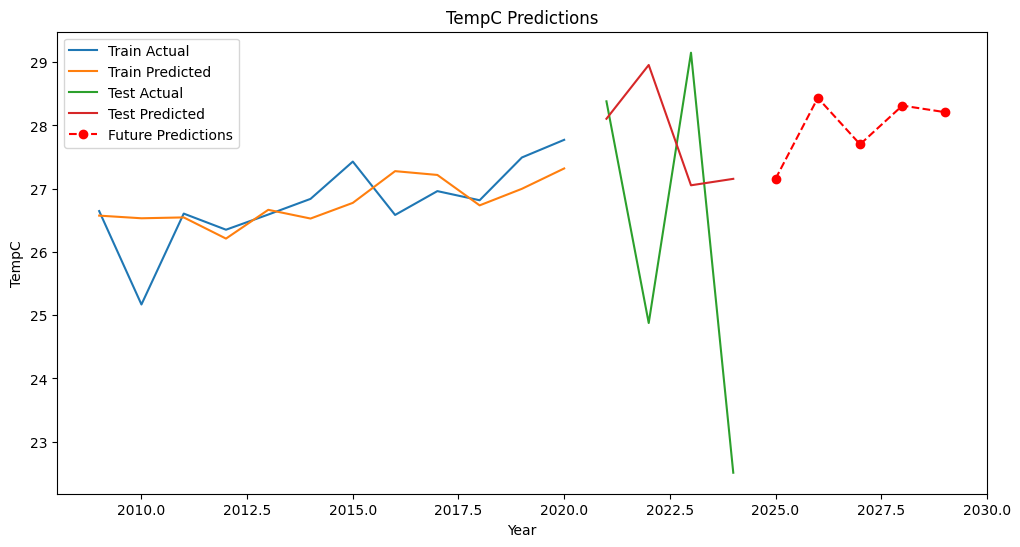


Future Predictions:
2025: 27.16
2026: 28.43
2027: 27.70
2028: 28.31
2029: 28.21


np.float64(28.209947532659882)

In [ ]:
path = "dataset/"
temp = pd.read_csv(path+'CREMP_Temperatures_2023.csv')
lstm_forecast(15 , temp, 'TempC')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Train RMSE: 0.1757
Train MAE: 0.1174

Test RMSE: 0.2526
Test MAE: 0.2234

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


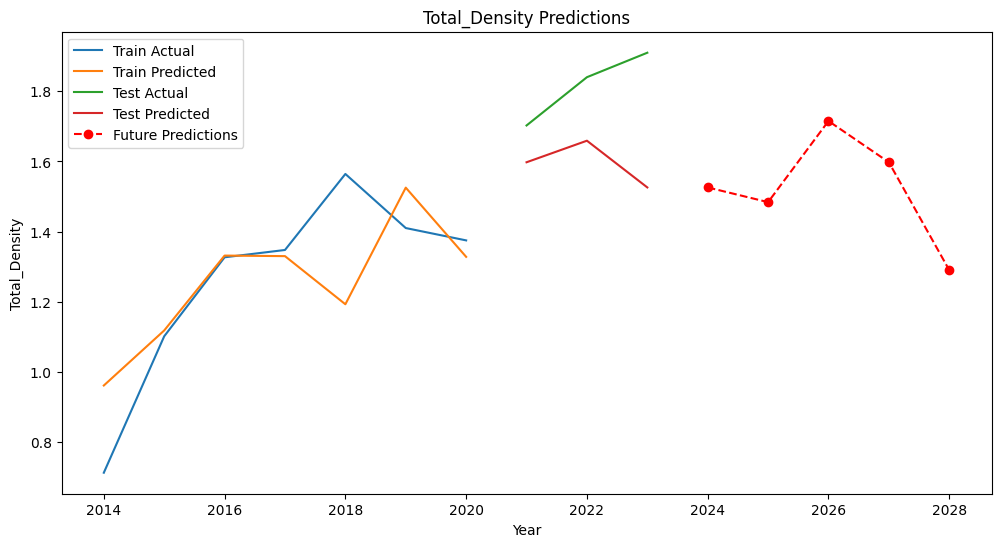


Future Predictions:
2024: 1.53
2025: 1.48
2026: 1.72
2027: 1.60
2028: 1.29


np.float64(1.289802522677364)

In [ ]:

lstm_forecast(40 , scor[['Total_Density', 'Year', 'SiteID']], 'Total_Density')

##### Model

In [5]:

def model_pipeline(model_type, df , target, cross_val=False, grid_search=False, transform=False):

  if target not in df.columns:
      raise ValueError("DataFrame must contain a target column as the dependent variable.")
  print(f'{yellow}{target}{reset}')

  scaler = StandardScaler()

  X = df.drop(target, axis=1)
  y = df[target]
  X_scaled = scaler.fit_transform(X)
  X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

  y_test_original = y_test
  X_grid, temp1, y_grid, temp2 = train_test_split(X_train, y_train, test_size=0.8, random_state=42)
  # Define model and parameter grid based on selected model type
  if model_type.lower() == 'random_forest':
      model = RandomForestRegressor(n_estimators=100,
                                    random_state=42,
                                    # max_depth=None,
                                    # max_features= 0.75,
                                    # min_samples_leaf=1,
                                    # min_samples_split =4
                                    )
      param_grid = {
          'n_estimators': [100],
          'max_depth': [None,2, 4 ],
          'min_samples_split': [2, 4,],
          'min_samples_leaf': [1, 3,],
          'max_features': ['auto', 'sqrt', 0.5, 0.75, 1.0]
      }
  elif model_type.lower() == 'xgboost':
      model = XGBRegressor(n_estimators=100,
                           random_state=42,
                          #  use_label_encoder=False,
                          #  eval_metric='rmse',
                          #  gamma = 1.0,
                          #  learning_rate = 0.1,
                          #  max_depth = 4,
                          #  subsample = 0.5
                           )
      param_grid = {
          'n_estimators': [100,],
          'max_depth': [2,4],
          'learning_rate': [0.01, 0.1],
          'gamma': [0,  1.0],
          'subsample': [0.5,  1.0],

      }
  elif model_type.lower() == 'catboost':
      model = CatBoostRegressor(iterations=300,
                                random_seed=42,
                                verbose=0,
                                # border_count = 64,
                                # depth = 5,
                                # l2_leaf_reg=0.5,
                                # learning_rate=0.1
                                )
      param_grid = {
           'iterations': [100, 300,],
            'depth': [3, 5, ],
            'learning_rate': [0.01, 0.1],
            'l2_leaf_reg': [0, 0.5, 1.0],
            'border_count': [32, 64],
      }
  else:
      raise ValueError("Unsupported model_type. Choose from 'random_forest', 'xgboost', 'catboost'.")

  # If grid_search flag is True, perform grid search hyperparameter tuning using 5-fold CV.
  if grid_search:
      print("Starting grid search for hyperparameter tuning...")
      print('data for grid search: ',X_grid.shape)
      grid = GridSearchCV(estimator=model, param_grid=param_grid,
                          cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
      grid.fit(X_grid, y_grid)
      print("Best parameters from Grid Search:", grid.best_params_)
      best_model = grid.best_estimator_
  else:
      best_model = model

  # If cross_val flag is True, perform 5-fold cross validation on the selected model.
  if cross_val:
      print("Performing 5-fold cross-validation...")
      cv_scores = cross_val_score(best_model, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
      print("Cross Validation Scores (neg MSE):", cv_scores)
      print("Mean CV Score (neg MSE):", cv_scores.mean())

  # Train the final model on the full dataset
  print("training the model ...")

  best_model.fit(X_train, y_train)

  print("Model training is complete.")

  # Extract and plot feature importance if available
  if hasattr(best_model, "feature_importances_"):
      importances = best_model.feature_importances_
      imp_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
      imp_df = imp_df.sort_values(by='importance', ascending=False)
      print("Feature Importances:")
      print(imp_df)
      imp_df.plot(kind='bar', x='feature', y='importance', figsize=(8,6),
                  title="Feature Importances")
      plt.ylabel("Importance")
      plt.tight_layout()
      plt.show()
  else:
      print("The selected model does not support a 'feature_importances_' attribute.")
  # ---------------------------- Prediction & Inversion ----------------------------- #
  print('prediction part ...')
  y_pred_original = best_model.predict(X_test)

  mask = ~np.isnan(y_pred_original)
  y_pred_clean = y_pred_original[mask]
  mask = ~np.isnan(y_pred_original).flatten()
  y_test_clean = y_test_original[mask]
  mse = mean_squared_error(y_test_clean, y_pred_clean)
  mae = mean_absolute_error(y_test_clean, y_pred_clean)
  r2 = r2_score(y_test_clean, y_pred_clean)
  rmse = np.sqrt(mse)
  print("RMSE:", rmse)
  print("MSE:", mse)
  print("MAE Absolute Error:", mae)
  print("R² Score:", r2)
  # --------------------------------------------------------------------------------- #
  # Return the fitted (best) model in case further analysis or predictions are needed.
  return best_model, X_test, y_test, y_pred_original



##### model training

Total_Density
training the model ...
Model training is complete.
Feature Importances:
              feature  importance
0  Total_Density_lag1   99.583181
1   StationID_encoded    0.343350
2               TempC    0.073468


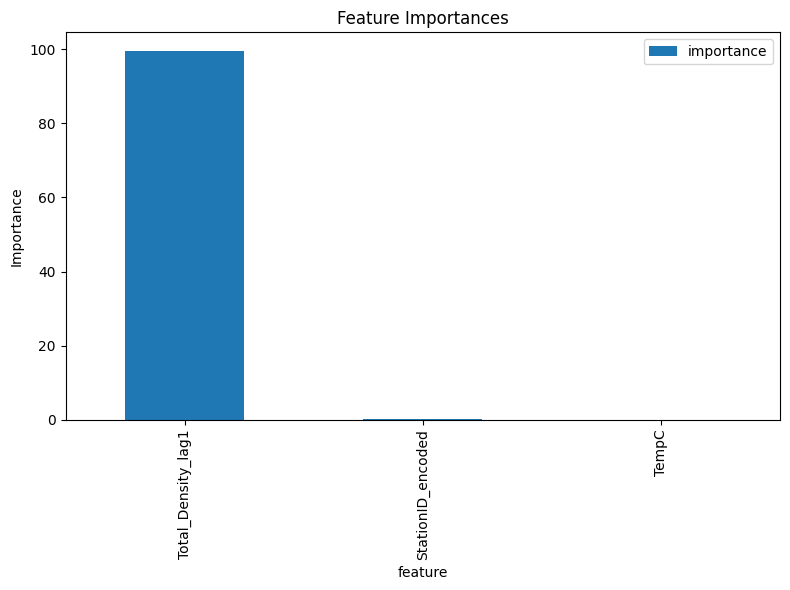

prediction part ...
RMSE: 0.10822654916612179
MSE: 0.011712985944406977
MAE Absolute Error: 0.013049369528662607
R² Score: 0.9995662685695188
Species_Richness
training the model ...
Model training is complete.
Feature Importances:
              feature  importance
2   StationID_encoded   45.882885
1  Total_Density_lag1   25.240514
0                Year   19.380378
3               TempC    9.496222


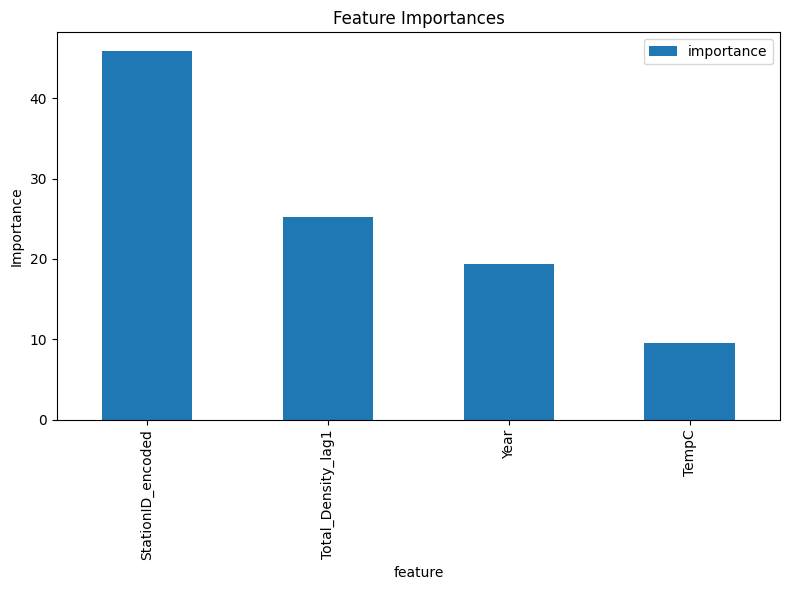

prediction part ...
RMSE: 0.37306034196729104
MSE: 0.13917401874875215
MAE Absolute Error: 0.2631762564951096
R² Score: 0.9843367720370712
Pcover_Total
training the model ...
Model training is complete.
Feature Importances:
                 feature  importance
0                   Year   95.457469
3      StationID_encoded    4.537360
4                  TempC    0.002248
2     Total_Density_lag1    0.001984
1  Species_Richness_lag1    0.000939


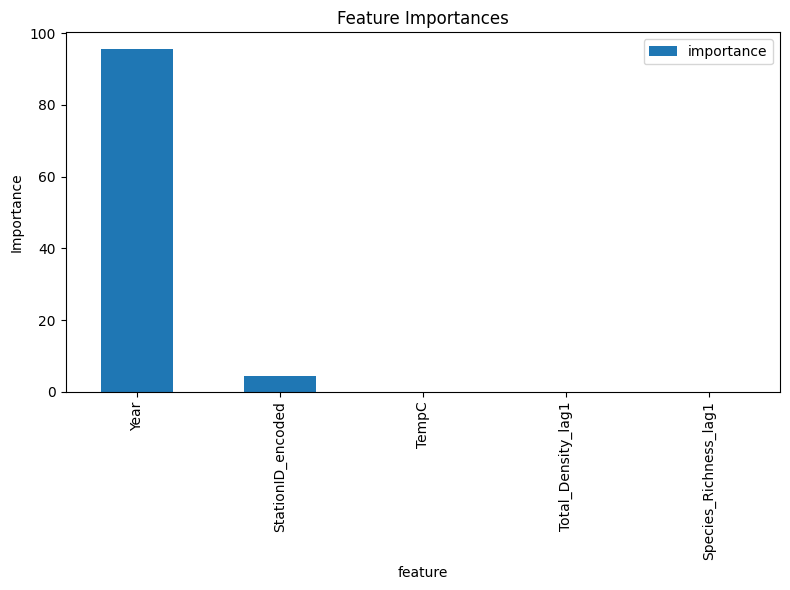

prediction part ...
RMSE: 0.12553472033873636
MSE: 0.01575896601052475
MAE Absolute Error: 0.08889333225277872
R² Score: 0.9999999549766625
Total_Density
training the model ...
Model training is complete.
Feature Importances:
              feature  importance
0  Total_Density_lag1    0.999492
1   StationID_encoded    0.000393
2               TempC    0.000115


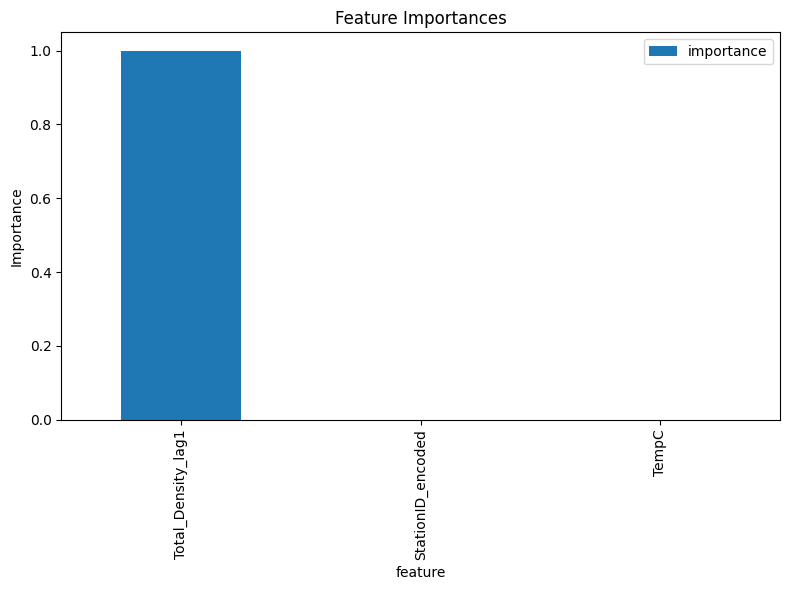

prediction part ...
RMSE: 0.09925930982116053
MSE: 0.009852410586173135
MAE Absolute Error: 0.0051426426819963554
R² Score: 0.9996351656052939
Species_Richness
training the model ...
Model training is complete.
Feature Importances:
              feature  importance
2   StationID_encoded    0.359590
1  Total_Density_lag1    0.278645
0                Year    0.269025
3               TempC    0.092739


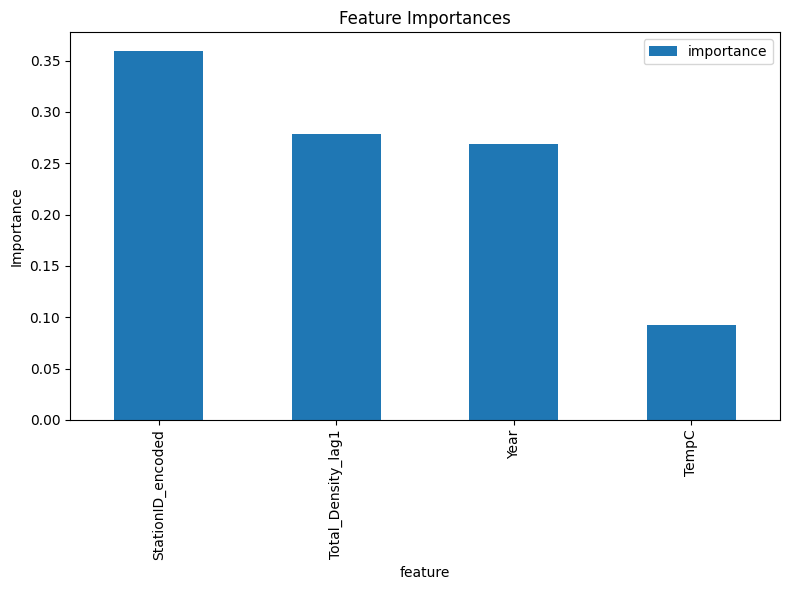

prediction part ...
RMSE: 0.31432066076186055
MSE: 0.09879747778177261
MAE Absolute Error: 0.21179898083209991
R² Score: 0.9888809323310852
Pcover_Total
training the model ...
Model training is complete.
Feature Importances:
                 feature  importance
0                   Year    0.997370
3      StationID_encoded    0.002627
4                  TempC    0.000001
2     Total_Density_lag1    0.000001
1  Species_Richness_lag1    0.000001


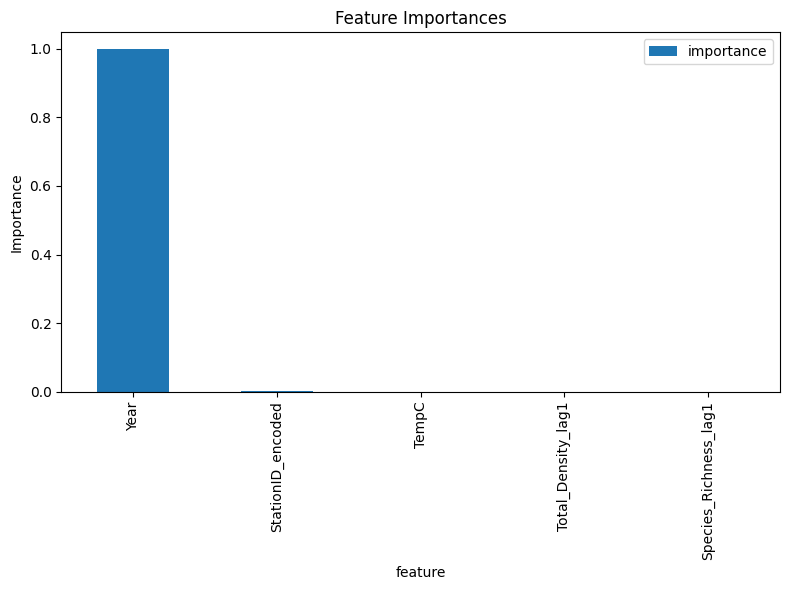

prediction part ...
RMSE: 0.338413445003042
MSE: 0.11452365975882693
MAE Absolute Error: 0.21724707181200617
R² Score: 0.9999996728061106


In [6]:
black = '\033[30m'
red = '\033[31m'
green = '\033[32m'
yellow = '\033[33m'
blue = '\033[34m'
magenta = '\033[35m'
cyan = '\033[36m'
white = '\033[37m'
orange = "\033[38;5;208m"
bold = '\033[1m'
reset = '\033[0m'

# ---------------------load the data --------------------
scor = pd.read_csv('scor_minimal.csv')
path = "dataset/"
temp = pd.read_csv(path+'CREMP_Temperatures_2023.csv')
con = [col for col in scor.columns if 'SCOR_ConditionCounts' in col]
pc = [col for col in scor.columns if 'Pcover_StonyCoralSpecies' in col]
duplicate = [col for col in scor.columns if '.1' in col]
scor.drop(columns=pc+con+duplicate, inplace=True)
# ---------------------lagged feature--------------------

for lag in [1, 2]:
    for col in ['TempC', 'Stations_Depth_ft', 'SCOR_RawData_LTA_cm2','healthy', 'Health_Score' ,'Species_Richness', 'Total_Density' ,
                'Total_Mortality_Percent',  'Pcover_Total', 'SCOR_RawData_Diameter_cm', 'SCOR_RawData_Height_cm' ]:
        scor[f"{col}_lag{lag}"] = scor[col].shift(lag)

# ---------------------station label encoding--------------------

le = LabelEncoder()
scor['StationID_encoded'] = le.fit_transform(scor['StationID'])

# ---------------------date as index--------------------

# scor.set_index('Date', inplace=True)

# ---------------------run the models--------------------
features = {
          "Total_Density" : [ 'Total_Density','Total_Density_lag1','StationID_encoded', 'TempC' , ],
          "Species_Richness":['Year', 'Total_Density_lag1',
                              # 'Species_Richness_lag1',
                              'Species_Richness', 'StationID_encoded', 'TempC' , ],
          "Pcover_Total":[ 'Year', 'Species_Richness_lag1', 'Total_Density_lag1',"Pcover_Total",'StationID_encoded', 'TempC' , ]
           }
cat_model_Total_Density, X_test, y_test , y_pred = model_pipeline(model_type="catboost",
                                                      df=scor[features["Total_Density"]],
                                                      cross_val=False,
                                                      grid_search=False,
                                                      transform=True,
                                                      target ="Total_Density" )

cat_model_Species_Richness, X_test, y_test , y_pred = model_pipeline(model_type="catboost",
                                                        df=scor[features["Species_Richness"]],
                                                        cross_val=False,
                                                        grid_search=False,
                                                        transform=True,
                                                        target ="Species_Richness" )

cat_model_Pcover_Total, X_test, y_test , y_pred = model_pipeline(model_type="catboost",
                                                        df=scor[features["Pcover_Total"]],
                                                        cross_val=False,
                                                        grid_search=False,
                                                        transform=True,
                                                        target ="Pcover_Total" )

xgb_model_Total_Density, X_test, y_test , y_pred = model_pipeline(model_type="xgboost",
                                                      df=scor[features["Total_Density"]],
                                                      cross_val=False,
                                                      grid_search=False,
                                                      transform=True,
                                                      target ="Total_Density" )

xgb_model_Species_Richness, X_test, y_test , y_pred = model_pipeline(model_type="xgboost",
                                                        df=scor[features["Species_Richness"]],
                                                        cross_val=False,
                                                        grid_search=False,
                                                        transform=True,
                                                        target ="Species_Richness" )

xgb_model_Pcover_Total, X_test, y_test , y_pred = model_pipeline(model_type="xgboost",
                                                        df=scor[features["Pcover_Total"]],
                                                        cross_val=False,
                                                        grid_search=False,
                                                        transform=True,
                                                        target ="Pcover_Total" )

##### Total_pipeline

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Train RMSE: 0.4769
Train MAE: 0.2957

Test RMSE: 2.1920
Test MAE: 1.3785

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


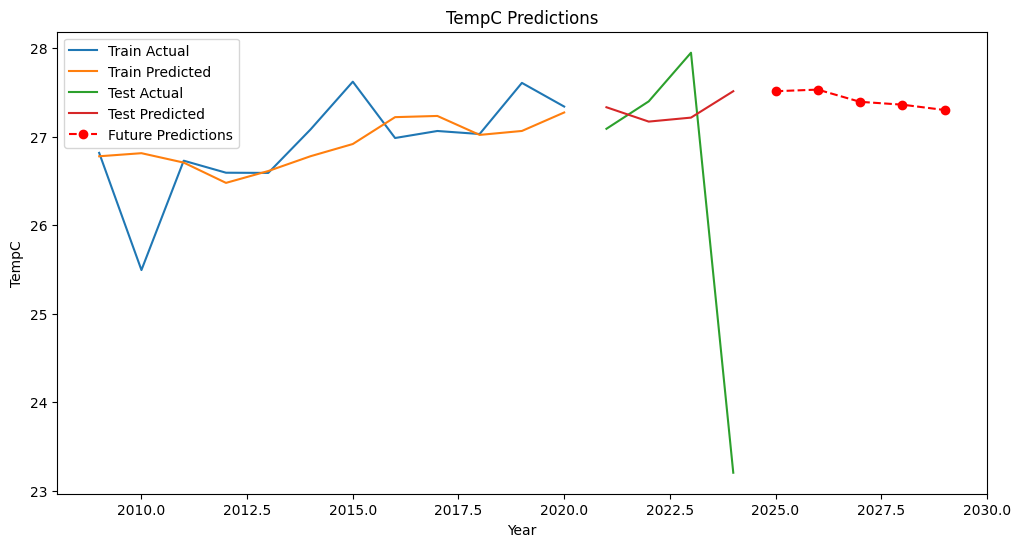


Future Predictions of TempC:
2025: 27.51
2026: 27.53
2027: 27.39
2028: 27.36
2029: 27.30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Train RMSE: 0.1643
Train MAE: 0.1435

Test RMSE: 1.3952
Test MAE: 1.1657

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


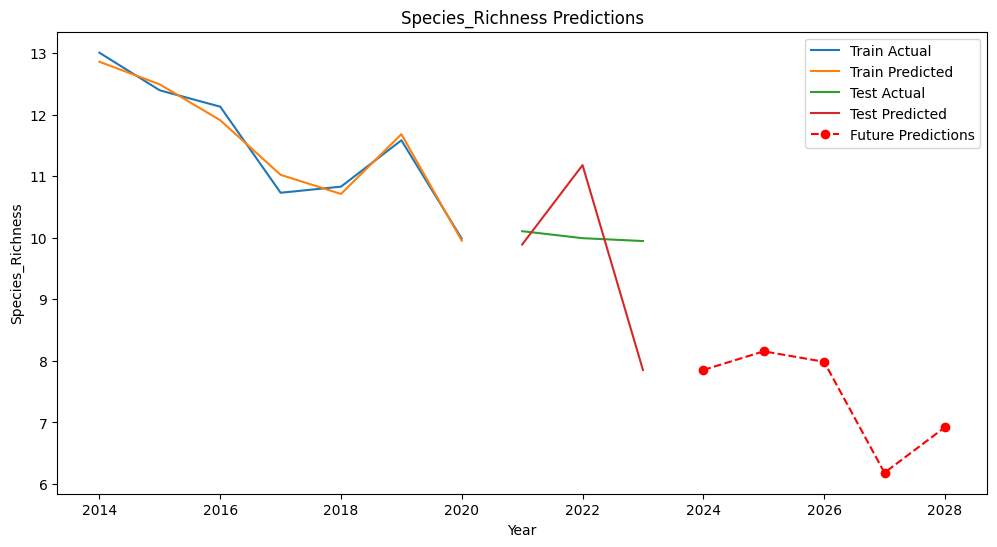


Future Predictions of Species_Richness:
2024: 7.85
2025: 8.16
2026: 7.98
2027: 6.18
2028: 6.92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Train RMSE: 0.0015
Train MAE: 0.0011

Test RMSE: 2.9183
Test MAE: 2.2214

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


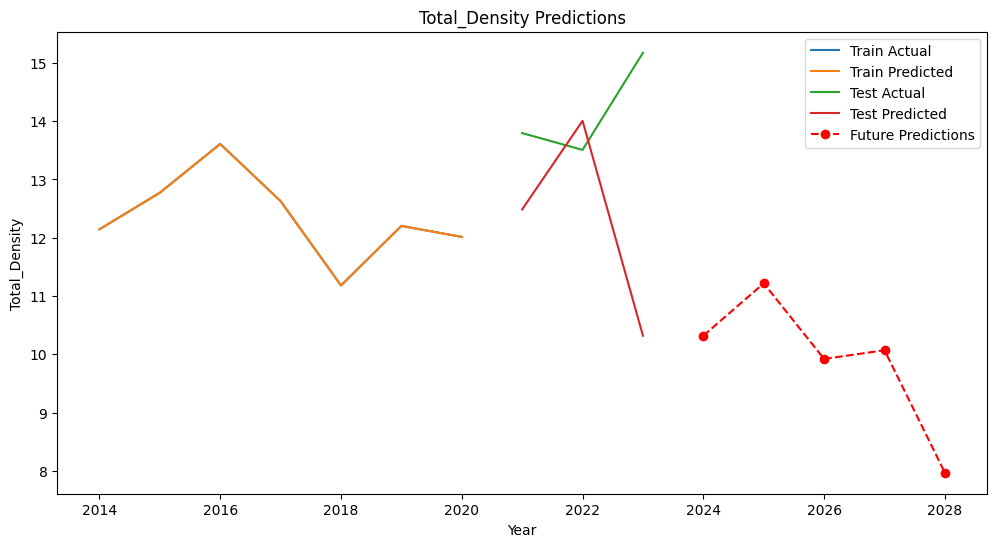


Future Predictions of Total_Density:
2024: 10.32
2025: 11.22
2026: 9.92
2027: 10.07
2028: 7.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Train RMSE: 7.0282
Train MAE: 6.8097

Test RMSE: 70.4687
Test MAE: 62.5803

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


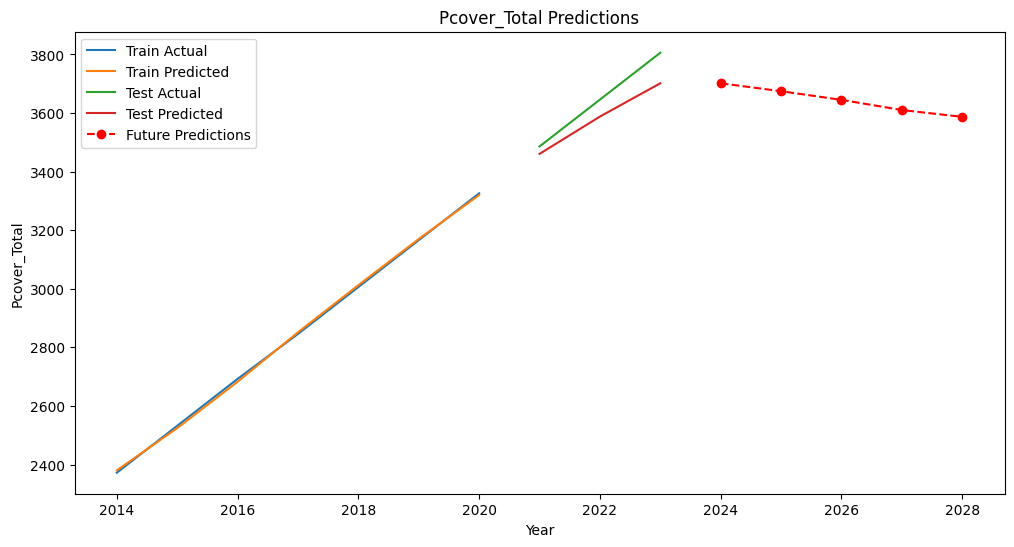


Future Predictions of Pcover_Total:
2024: 3701.65
2025: 3674.59
2026: 3645.09
2027: 3610.33
2028: 3587.08
Total_Density1 -3.120980806067143
Total_Density2 15.149015426635742
mean_Total_Density 6.0140173102842995
Species_Richness1 6.962098357051615
Species_Richness2 6.589621067047119
mean_Species_Richness 6.7758597120493675
Pcover_Total1 3915.005969620631
Pcover_Total2 3916.481689453125
mean_Pcover_Total 3915.743829536878
Total_Density1 -3.120980806067143
Total_Density2 15.149015426635742
mean_Total_Density 6.0140173102842995
Species_Richness1 6.962098357051615
Species_Richness2 6.589621067047119
mean_Species_Richness 6.7758597120493675
Pcover_Total1 3915.005969620631
Pcover_Total2 3916.481689453125
mean_Pcover_Total 3915.743829536878
Total_Density1 -3.120980806067143
Total_Density2 15.149015426635742
mean_Total_Density 6.0140173102842995
Species_Richness1 6.962098357051615
Species_Richness2 6.589621067047119
mean_Species_Richness 6.7758597120493675
Pcover_Total1 3915.005969620631
Pcov

{'Pcover_Total': [np.float64(3808.699147980539),
  np.float64(3808.699147980539),
  np.float64(3808.699147980539),
  np.float64(3808.699147980539),
  np.float64(3808.699147980539)],
 'Total_Density': [np.float64(8.16623029652955),
  np.float64(8.16623029652955),
  np.float64(8.16623029652955),
  np.float64(8.16623029652955),
  np.float64(8.16623029652955)],
 'Species_Richness': [np.float64(7.3140484156550105),
  np.float64(7.3140484156550105),
  np.float64(7.3140484156550105),
  np.float64(7.3140484156550105),
  np.float64(7.3140484156550105)]}

In [12]:

"""
order of forecasting :
1-total density ==> features: ['Total_Density_lag1','StationID_encoded' ,'TempC' , ]
2-species richness ==> features: ['Year','Total_Density_lag1', 'StationID_encoded' ,'TempC' , ]
3-Pcover ==> features:  [ 'Year', 'Species_Richness_lag1', 'Total_Density_lag1','StationID_encoded','TempC' , ]
"""

def Total_pipeline(StationID):
  StationID_encoded = int(scor[scor['StationID']== StationID]['StationID_encoded'].iloc[0])
  year = 2023
  predicted = {
       "Total_Density" : [float(scor[(scor['Year'] == year) & (scor['StationID'] == StationID)]['Total_Density'].iloc[0])],
        "Species_Richness":[float(scor[(scor['Year'] == year) & (scor['StationID'] == StationID)]['Species_Richness'].iloc[0])],
        "Pcover_Total":[float(scor[(scor['Year'] == year) & (scor['StationID'] == StationID)]['Pcover_Total'].iloc[0])],
        "TempC":[float(scor[(scor['Year'] == year) & (scor['StationID'] == StationID)]['TempC'].iloc[0] )]
  }

  SiteID = int(scor[scor['StationID']== StationID]['SiteID'].iloc[0])
  future_temp = lstm_forecast(SiteID , temp, 'TempC')
  future_species_richness = lstm_forecast(SiteID , scor[['Species_Richness', 'Year', 'SiteID']], 'Species_Richness')
  future_Total_Density = lstm_forecast(SiteID , scor[['Total_Density', 'Year', 'SiteID']], 'Total_Density')
  future_Pcover_Total = lstm_forecast(SiteID ,scor[['Pcover_Total', 'Year', 'SiteID']], 'Pcover_Total')

  def forecast ( target, features, model):
      y_pred = model.predict([features])
      return float(y_pred[0])

  for step in range(5):

    if year ==2024:
      SiteID = int(scor[scor['StationID']== StationID]['SiteID'].iloc[0])
      # print(f'SiteID {SiteID} {StationID}')
      grouped_data = temp.groupby(['SiteID', 'Year'])['TempC'].mean()
      grouped_data = grouped_data.reset_index()
      data = grouped_data[grouped_data['SiteID'] == SiteID]
      # print(data[(data['Year'] == year) & (data['SiteID'] == SiteID)]['TempC'])
      if(len(data[(data['Year'] == year) & (data['SiteID'] == SiteID)]['TempC'])):
        predicted['TempC'].append(float(data[(data['Year'] == year) & (data['SiteID'] == SiteID)]['TempC']))
      else:
        raise Exception( f'the data for this Station {StationID} doese not have temprerature')

    elif year==2025 :
      for y, t in future_temp.items():
        if y>2024:
          predicted['TempC'].append(t)



    # Total_Density
    # features: ['Total_Density_lag1','StationID_encoded' ,'TempC' , ]
    features = [
                predicted["Total_Density"][step],
                StationID_encoded,
                predicted["TempC"][step],
                ]
    Total_Density1 = forecast('Total_Density', features, cat_model_Total_Density)
    Total_Density2 = forecast('Total_Density', features, xgb_model_Total_Density)
    mean_Total_Density = (Total_Density2+Total_Density1) / 2
    predicted['Total_Density'].append(mean_Total_Density)

    print(f'Total_Density1 {Total_Density1}')
    print(f'Total_Density2 {Total_Density2}')
    print(f'mean_Total_Density {mean_Total_Density}')

    # Species_Richness
    # features: ['Year','Total_Density_lag1', 'StationID_encoded', 'TempC']
    features = [year,
                predicted["Total_Density"][step],
                # predicted["Species_Richness"][step],
                StationID_encoded,
                predicted["TempC"][step],
                ]
    Species_Richness1 = forecast('Species_Richness', features, cat_model_Species_Richness)
    Species_Richness2 = forecast('Species_Richness', features, xgb_model_Species_Richness)
    mean_Species_Richness = (Species_Richness2 + Species_Richness1) / 2
    predicted['Species_Richness'].append(mean_Species_Richness)

    print(f'Species_Richness1 {Species_Richness1}')
    print(f'Species_Richness2 {Species_Richness2}')
    print(f'mean_Species_Richness {mean_Species_Richness}')
    # Pcover_Total
    # features:[ 'Year', 'Species_Richness_lag1', 'Total_Density_lag1','StationID_encoded','TempC']
    features = [year,
                predicted["Species_Richness"][step],
                predicted["Total_Density"][step],
                StationID_encoded,
                predicted["TempC"][step],

                ]
    Pcover_Total1 = forecast('Pcover_Total', features, cat_model_Pcover_Total)
    Pcover_Total2 = forecast('Pcover_Total', features, xgb_model_Pcover_Total)
    mean_Pcover_Total = (Pcover_Total2 + Pcover_Total1) / 2
    predicted['Pcover_Total'].append(mean_Pcover_Total)

    print(f'Pcover_Total1 {Pcover_Total1}')
    print(f'Pcover_Total2 {Pcover_Total2}')
    print(f'mean_Pcover_Total {mean_Pcover_Total}')


    year+=1
  final ={'Pcover_Total':[],
          'Total_Density':[],
          'Species_Richness':[],
          }
  for i in range(len(predicted['Pcover_Total'])):
    year = 2024
    if i>0:
      final['Pcover_Total'].append(( predicted['Pcover_Total'][i] + future_Pcover_Total[year]) / 2)
      final['Total_Density'].append(( predicted['Total_Density'][i] + future_Total_Density[year]) / 2)
      final['Species_Richness'].append( ( predicted['Species_Richness'][i] + future_species_richness[year]) / 2)
      year += 1


  print (f'{yellow}Predicted values for station :{StationID}{reset}')

  return final , future_Pcover_Total , future_Total_Density , future_species_richness


predicted , future_Pcover_Total , future_Total_Density , future_species_richness = Total_pipeline(StationID=351)
predicted

In [ ]:
scor['StationID'].unique()

array([181, 343, 342, 344, 341, 573, 574, 572, 354, 561, 562, 554, 563,
       552, 553, 551, 571, 564, 353, 351, 352, 251, 252, 771, 764, 772,
       761, 754, 763, 762, 232, 231, 242, 241, 752, 753, 751, 773, 774,
       184, 182, 183, 513, 512, 511, 504, 514, 503, 701, 501, 502, 523,
       524, 531, 544, 532, 534, 541, 533, 543, 542, 521, 522, 733, 734,
       724, 744, 743, 741, 742, 732, 731, 703, 702, 723, 722, 721, 704,
       321, 304, 222, 212, 221, 211, 301, 302, 303, 324, 323, 333, 332,
       331, 334, 322, 364, 363, 614, 361, 613, 611, 604, 612, 362, 374,
       262, 801, 802, 803, 784, 791, 793, 794, 792, 812, 813, 814, 804,
       811, 261, 782, 781, 783, 383, 384, 391, 392, 393, 381, 382, 581,
       583, 582, 584, 371, 594, 593, 603, 601, 602, 591, 592, 373, 394,
       402, 403, 401, 404, 372, 214, 213, 223, 224, 253, 244, 243, 254,
       234, 233, 263, 264])

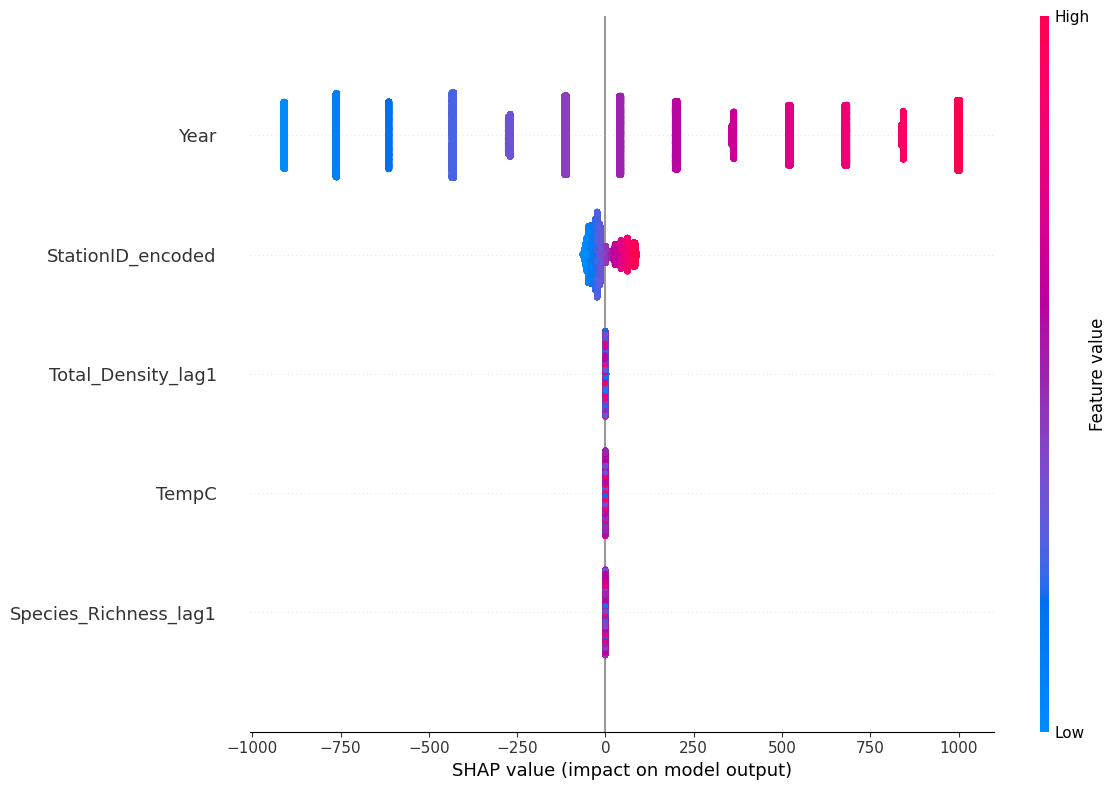

In [14]:
import shap

explainer = shap.TreeExplainer(cat_model_Pcover_Total)
shap_values = explainer.shap_values(X_test)

fig = shap.summary_plot(shap_values, X_test, show=False)
plt.gcf().set_size_inches(12, 8)
plt.rcParams.update({'font.size': 10})
plt.tight_layout()
plt.show()


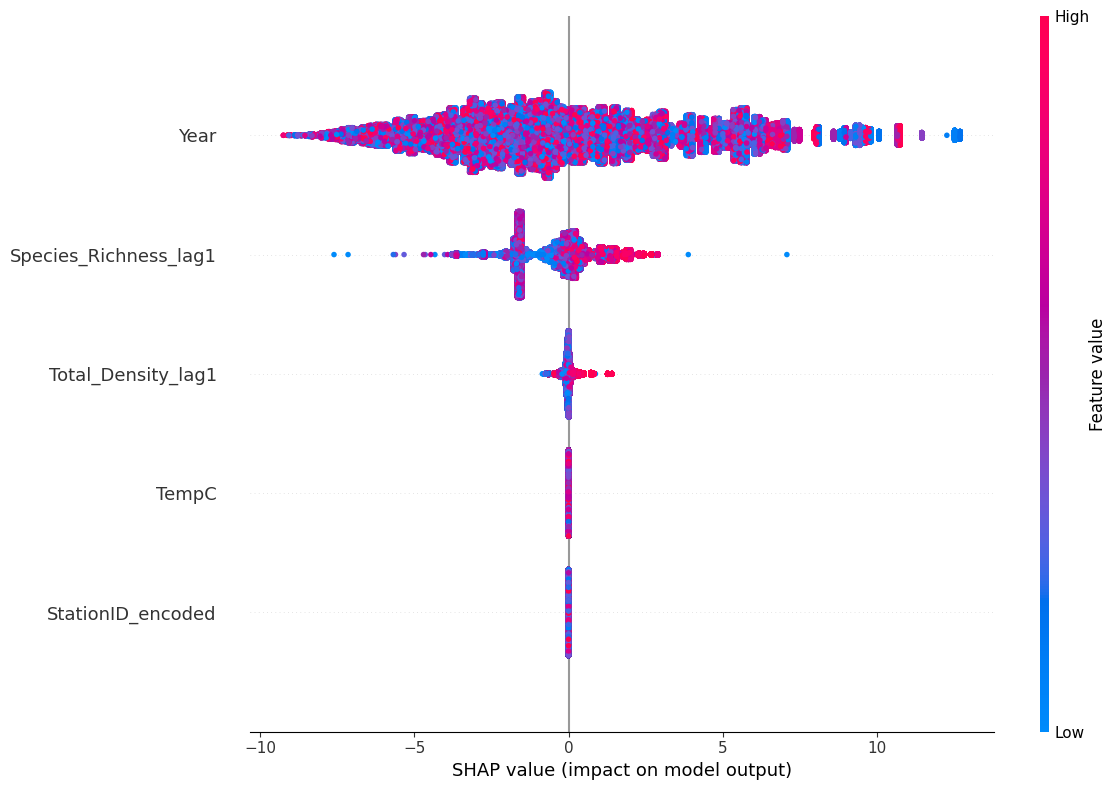

In [15]:

explainer = shap.TreeExplainer(cat_model_Total_Density)
shap_values = explainer.shap_values(X_test)

fig = shap.summary_plot(shap_values, X_test, show=False)
plt.gcf().set_size_inches(12, 8)
plt.rcParams.update({'font.size': 10})
plt.tight_layout()
plt.show()

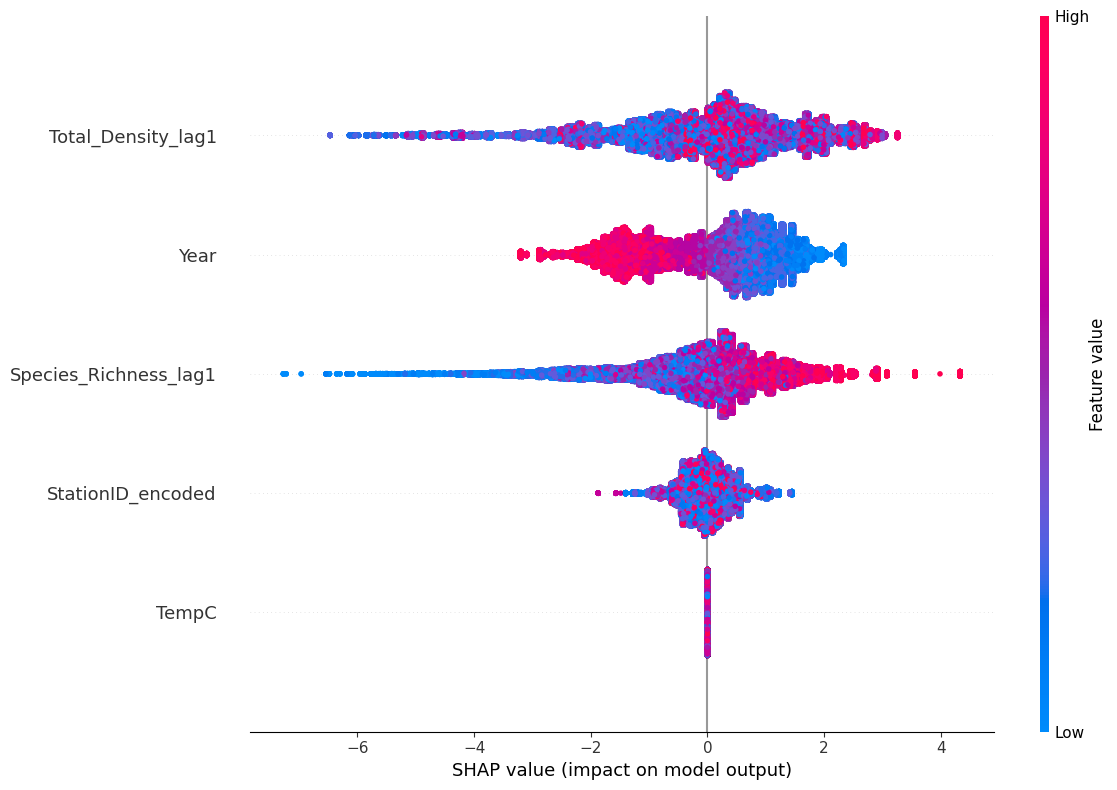

In [16]:

explainer = shap.TreeExplainer(cat_model_Species_Richness)
shap_values = explainer.shap_values(X_test)

fig = shap.summary_plot(shap_values, X_test, show=False)
plt.gcf().set_size_inches(12, 8)
plt.rcParams.update({'font.size': 10})
plt.tight_layout()
plt.show()

### Octocoral

In [ ]:
octo

In [ ]:
octo = pd.read_csv('merged_octo.csv')
print(octo.shape)
octo.columns
meanheight = [col for col in octo.columns if 'OCTO_MeanHeight' in col]
octo['total_meanheight'] = octo[meanheight].sum(axis = 1)
targets = ['OCTO_Density_Total_Octocorals' , 'Pcover_TaxaGroups_Octocoral' ]
features = ['TempC' , 'Stations_Depth_ft', 'StationID' , 'OCTO_RawData_Height_cm', 'total_meanheight' , 'Stations_length_m']

(108203, 50)


Index(['Year', 'SiteID', 'StationID', 'OCTO_RawData_SPP_Code',
       'OCTO_RawData_sciName', 'OCTO_RawData_Height_cm', 'Month',
       'OCTO_Density_Eunicea_calyculata', 'OCTO_Density_Gorgonia_ventalina',
       'OCTO_Density_Pseudopterogorgia_americana',
       'OCTO_Density_Pseudopterogorgia_bipinnata',
       'OCTO_Density_Eunicea_flexuosa', 'OCTO_Density_Pseudoplexaura_porosa',
       'OCTO_Density_Total_Octocorals', 'Date', 'Subregion', 'Habitat',
       'Site_name_x', 'OCTO_MeanHeight_Eunicea_calyculata',
       'OCTO_MeanHeight_Gorgonia_ventalina',
       'OCTO_MeanHeight_Pseudopterogorgia_americana',
       'OCTO_MeanHeight_Pseudopterogorgia_bipinnata',
       'OCTO_MeanHeight_Eunicea_flexuosa',
       'OCTO_MeanHeight_Pseudoplexaura_porosa',
       'Pcover_TaxaGroups_Surveyed_all_years', 'Pcover_TaxaGroups_points',
       'Pcover_TaxaGroups_Cyanobacteria', 'Pcover_TaxaGroups_Macroalgae',
       'Pcover_TaxaGroups_Octocoral', 'Pcover_TaxaGroups_Others',
       'Pcover_TaxaGrou

#### model

In [ ]:
object_cols =[]
for col in octo.columns:
  if octo[col].dtype== 'object':
    # print(f'{col}: {octo[col].nunique()}{octo[col].unique()}')
    object_cols.append(col)
object_cols

['OCTO_RawData_SPP_Code',
 'OCTO_RawData_sciName',
 'Date',
 'Subregion',
 'Habitat',
 'Site_name_x',
 'Pcover_TaxaGroups_Surveyed_all_years',
 'Site_name_y',
 'Site_name']

In [ ]:
octo = octo.drop(columns=object_cols)

In [ ]:
non_station_Cols = [col for col in octo.columns if 'station' not in col.lower()]

for target in ['OCTO_Density_Total_Octocorals' , 'Pcover_TaxaGroups_Octocoral' ]:
  correlations1 = octo[non_station_Cols].corr()[target]
  selected_cols = correlations1[abs(correlations1) > 0.4].index.tolist()
  data = octo[selected_cols]
  selected_cols.remove(target)
  corr_matrix = octo[selected_cols].corr()
  threshold = 0.9
  high_corr_pairs = []
  for i in range(len(corr_matrix.columns)):
      for j in range(i + 1, len(corr_matrix.columns)):
          if abs(corr_matrix.iloc[i, j]) > threshold:
              high_corr_pairs.append((corr_matrix.index[i], corr_matrix.columns[j]))

  features_to_remove = set()
  for feature1, feature2 in high_corr_pairs:
      features_to_remove.add(feature2)

  print(f'{bold}{yellow} {target} {reset}  {[item for item in selected_cols if item not in list(features_to_remove)]}')

 OCTO_Density_Total_Octocorals   ['OCTO_Density_Gorgonia_ventalina', 'OCTO_Density_Pseudopterogorgia_americana', 'OCTO_MeanHeight_Gorgonia_ventalina', 'OCTO_MeanHeight_Pseudopterogorgia_bipinnata', 'OCTO_MeanHeight_Pseudoplexaura_porosa']
 Pcover_TaxaGroups_Octocoral   ['SiteID', 'OCTO_Density_Pseudoplexaura_porosa', 'OCTO_MeanHeight_Gorgonia_ventalina', 'OCTO_MeanHeight_Pseudopterogorgia_americana', 'Pcover_TaxaGroups_Substrate']


In [ ]:
 ['TempC' , 'Stations_Depth_ft' ]

##### LSTM

In [ ]:
# Install required package
# !pip install tensorflow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


def lstm_forecast(SiteID , temp, target):

  grouped_data = temp.groupby(['SiteID', 'Year'])[target].mean()
  grouped_data = grouped_data.reset_index()
  data = grouped_data[grouped_data['SiteID'] == SiteID ][['Year',target]]

  # Data preprocessing function
  def create_dataset(data, n_lags=1):
      df = pd.DataFrame(data)
      cols = [df.shift(i) for i in range(n_lags, 0, -1)] + [df]
      df_supervised = pd.concat(cols, axis=1)
      df_supervised.columns = [f't-{i}' for i in range(n_lags, 0, -1)] + ['t']
      df_supervised.dropna(inplace=True)
      return df_supervised.values

  # Create supervised dataset
  n_lags = 3  # Using 3 previous years to predict next year
  dataset = create_dataset(data[target], n_lags=n_lags)

  # Train-test split
  train_size = int(np.ceil(len(dataset)*0.7))  # First 15 years for training
  train, test = dataset[:train_size], dataset[train_size:]

  # Scale data (-1 to 1)
  scaler = MinMaxScaler(feature_range=(-1, 1))
  train_scaled = scaler.fit_transform(train)
  test_scaled = scaler.transform(test)

  # Reshape data for LSTM [samples, timesteps, features]
  def reshape_data(data, n_lags):
      X = data[:, :-1]
      y = data[:, -1]
      return X.reshape(X.shape[0], 1, n_lags), y

  X_train, y_train = reshape_data(train_scaled, n_lags)
  X_test, y_test = reshape_data(test_scaled, n_lags)

  # Build LSTM model
  model = Sequential()
  model.add(LSTM(50, activation='tanh', input_shape=(1, n_lags)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')

  # Train model
  history = model.fit(X_train, y_train, epochs=300, batch_size=1, verbose=0)

  # Model evaluation
  def inverse_scale(data, scaler, n_features):
      dummy = np.zeros((len(data), n_features+1))
      dummy[:, -1] = data
      return scaler.inverse_transform(dummy)[:, -1]

  train_pred = inverse_scale(model.predict(X_train).flatten(), scaler, n_lags)
  test_pred = inverse_scale(model.predict(X_test).flatten(), scaler, n_lags)

  train_actual = inverse_scale(y_train, scaler, n_lags)
  test_actual = inverse_scale(y_test, scaler, n_lags)

  # Calculate metrics
  def print_metrics(actual, pred, set_name):
      rmse = np.sqrt(mean_squared_error(actual, pred))
      mae = mean_absolute_error(actual, pred)
      print(f"{set_name} RMSE: {rmse:.4f}")
      print(f"{set_name} MAE: {mae:.4f}\n")

  print_metrics(train_actual, train_pred, "Train")
  print_metrics(test_actual, test_pred, "Test")
  data.set_index('Year', inplace=True)

  # Plot historical predictions
  plt.figure(figsize=(12,6))
  plt.plot(data.index[n_lags:train_size+n_lags], train_actual, label='Train Actual')
  plt.plot(data.index[n_lags:train_size+n_lags], train_pred, label='Train Predicted')
  plt.plot(data.index[train_size+n_lags:], test_actual, label='Test Actual')
  plt.plot(data.index[train_size+n_lags:], test_pred, label='Test Predicted')

  # Predict next 5 years
  last_window = test_scaled[-1, :-1].reshape(1, 1, n_lags)
  future_preds = []
  for _ in range(5):
      pred = model.predict(last_window)
      future_preds.append(pred[0,0])
      last_window = np.append(last_window[:, :, 1:], pred).reshape(1, 1, n_lags)

  # Inverse scale future predictions
  future_temps = inverse_scale(np.array(future_preds), scaler, n_lags)
  future_years = np.arange(data.index[-1]+1, data.index[-1]+6)

  # Plot future predictions
  plt.plot(future_years, future_temps, 'ro--', label='Future Predictions')
  plt.title(f'{target} Predictions')
  plt.xlabel('Year')
  plt.ylabel(f'{target}')
  plt.legend()
  plt.show()
  temps={}

  # Print future predictions
  print(f"\nFuture Predictions of {target}:")
  for year, temp in zip(future_years, future_temps):
      print(f"{year}: {temp:.2f}")
      temps.update({year:temp})
  return temps


##### Model

In [ ]:

def model_pipeline(model_type, df , target, cross_val=False, grid_search=False, transform=False):

  if target not in df.columns:
      raise ValueError("DataFrame must contain a target column as the dependent variable.")
  print(f'{yellow}{target}{reset}')

  scaler = StandardScaler()

  X = df.drop(target, axis=1)
  y = df[target]
  X_scaled = scaler.fit_transform(X)
  X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

  y_test_original = y_test
  X_grid, temp1, y_grid, temp2 = train_test_split(X_train, y_train, test_size=0.8, random_state=42)
  # Define model and parameter grid based on selected model type
  if model_type.lower() == 'random_forest':
      model = RandomForestRegressor(n_estimators=100,
                                    random_state=42,
                                    # max_depth=None,
                                    # max_features= 0.75,
                                    # min_samples_leaf=1,
                                    # min_samples_split =4
                                    )
      param_grid = {
          'n_estimators': [100],
          'max_depth': [None,2, 4 ],
          'min_samples_split': [2, 4,],
          'min_samples_leaf': [1, 3,],
          'max_features': ['auto', 'sqrt', 0.5, 0.75, 1.0]
      }
  elif model_type.lower() == 'xgboost':
      model = XGBRegressor(n_estimators=100,
                           random_state=42,
                          #  use_label_encoder=False,
                          #  eval_metric='rmse',
                          #  gamma = 1.0,
                          #  learning_rate = 0.1,
                          #  max_depth = 4,
                          #  subsample = 0.5
                           )
      param_grid = {
          'n_estimators': [100,],
          'max_depth': [2,4],
          'learning_rate': [0.01, 0.1],
          'gamma': [0,  1.0],
          'subsample': [0.5,  1.0],

      }
  elif model_type.lower() == 'catboost':
      model = CatBoostRegressor(iterations=300,
                                random_seed=42,
                                verbose=0,
                                # border_count = 64,
                                # depth = 5,
                                # l2_leaf_reg=0.5,
                                # learning_rate=0.1
                                )
      param_grid = {
           'iterations': [100, 300,],
            'depth': [3, 5, ],
            'learning_rate': [0.01, 0.1],
            'l2_leaf_reg': [0, 0.5, 1.0],
            'border_count': [32, 64],
      }
  else:
      raise ValueError("Unsupported model_type. Choose from 'random_forest', 'xgboost', 'catboost'.")

  # If grid_search flag is True, perform grid search hyperparameter tuning using 5-fold CV.
  if grid_search:
      print("Starting grid search for hyperparameter tuning...")
      print('data for grid search: ',X_grid.shape)
      grid = GridSearchCV(estimator=model, param_grid=param_grid,
                          cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
      grid.fit(X_grid, y_grid)
      print("Best parameters from Grid Search:", grid.best_params_)
      best_model = grid.best_estimator_
  else:
      best_model = model

  # If cross_val flag is True, perform 5-fold cross validation on the selected model.
  if cross_val:
      print("Performing 5-fold cross-validation...")
      cv_scores = cross_val_score(best_model, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
      print("Cross Validation Scores (neg MSE):", cv_scores)
      print("Mean CV Score (neg MSE):", cv_scores.mean())

  # Train the final model on the full dataset
  print("training the model ...")

  best_model.fit(X_train, y_train)

  print("Model training is complete.")

  # Extract and plot feature importance if available
  if hasattr(best_model, "feature_importances_"):
      importances = best_model.feature_importances_
      imp_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
      imp_df = imp_df.sort_values(by='importance', ascending=False)
      print("Feature Importances:")
      print(imp_df)
      imp_df.plot(kind='bar', x='feature', y='importance', figsize=(8,6),
                  title="Feature Importances")
      plt.ylabel("Importance")
      plt.tight_layout()
      plt.show()
  else:
      print("The selected model does not support a 'feature_importances_' attribute.")
  # ---------------------------- Prediction & Inversion ----------------------------- #
  print('prediction part ...')
  y_pred_original = best_model.predict(X_test)

  mask = ~np.isnan(y_pred_original)
  y_pred_clean = y_pred_original[mask]
  mask = ~np.isnan(y_pred_original).flatten()
  y_test_clean = y_test_original[mask]
  mse = mean_squared_error(y_test_clean, y_pred_clean)
  mae = mean_absolute_error(y_test_clean, y_pred_clean)
  r2 = r2_score(y_test_clean, y_pred_clean)
  rmse = np.sqrt(mse)
  print("RMSE:", rmse)
  print("MSE:", mse)
  print("MAE Absolute Error:", mae)
  print("R² Score:", r2)
  # --------------------------------------------------------------------------------- #
  # Return the fitted (best) model in case further analysis or predictions are needed.
  return best_model, X_test, y_test, y_pred_original



##### model training

Total_Density
training the model ...
Model training is complete.
Feature Importances:
              feature  importance
0  Total_Density_lag1   99.583181
1   StationID_encoded    0.343350
2               TempC    0.073468


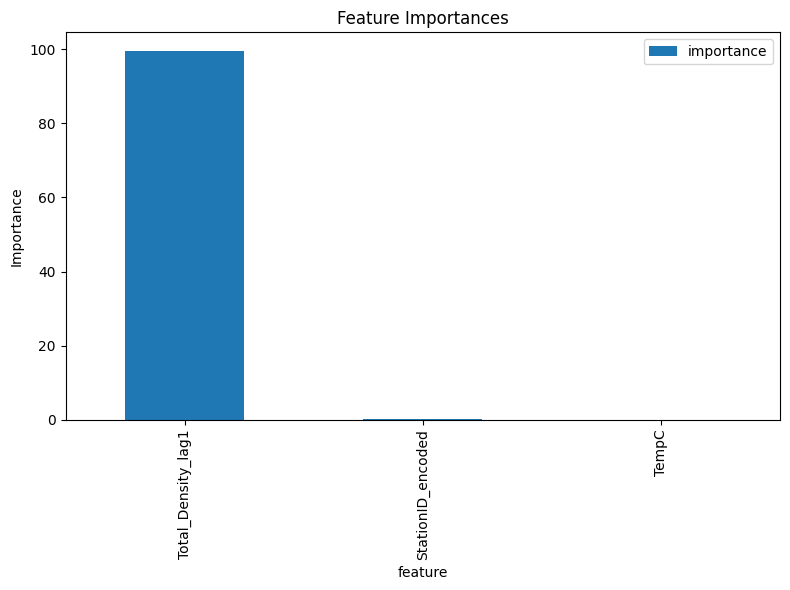

prediction part ...
RMSE: 0.10822654916612179
MSE: 0.011712985944406977
MAE Absolute Error: 0.013049369528662607
R² Score: 0.9995662685695188
Species_Richness
training the model ...
Model training is complete.
Feature Importances:
              feature  importance
2   StationID_encoded   45.882885
1  Total_Density_lag1   25.240514
0                Year   19.380378
3               TempC    9.496222


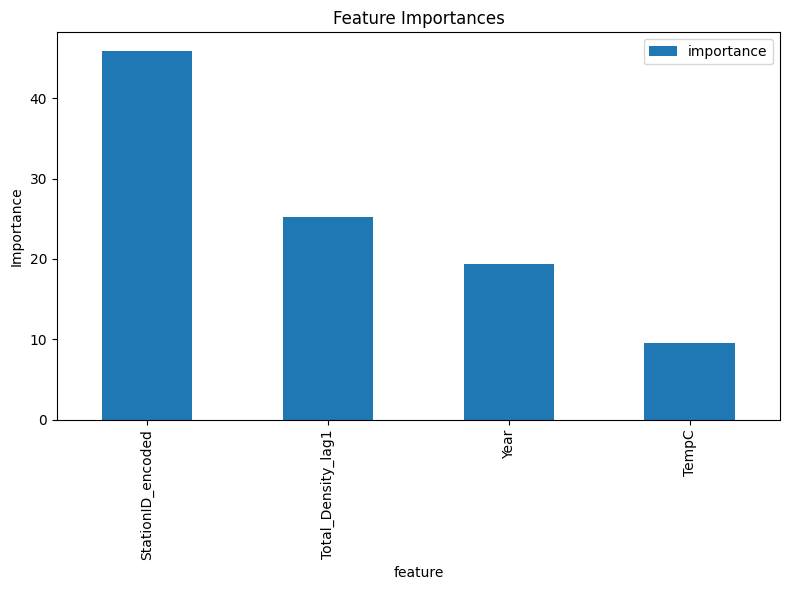

prediction part ...
RMSE: 0.37306034196729104
MSE: 0.13917401874875215
MAE Absolute Error: 0.2631762564951096
R² Score: 0.9843367720370712
Pcover_Total
training the model ...
Model training is complete.
Feature Importances:
                 feature  importance
0                   Year   95.457469
3      StationID_encoded    4.537360
4                  TempC    0.002248
2     Total_Density_lag1    0.001984
1  Species_Richness_lag1    0.000939


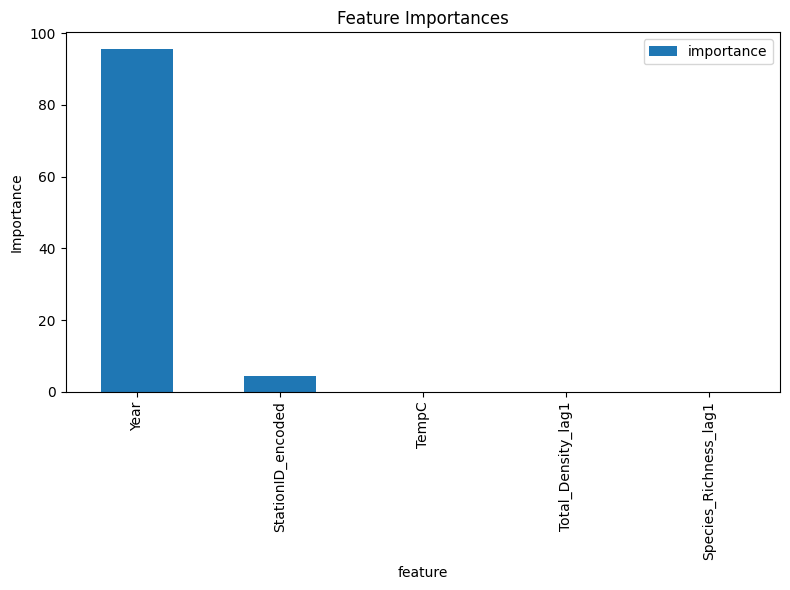

prediction part ...
RMSE: 0.12553472033873636
MSE: 0.01575896601052475
MAE Absolute Error: 0.08889333225277872
R² Score: 0.9999999549766625
Total_Density
training the model ...
Model training is complete.
Feature Importances:
              feature  importance
0  Total_Density_lag1    0.999492
1   StationID_encoded    0.000393
2               TempC    0.000115


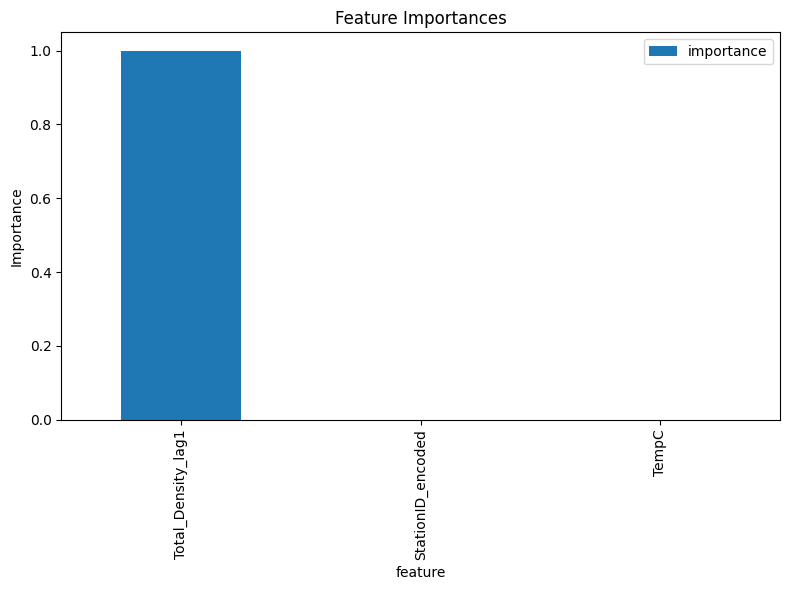

prediction part ...
RMSE: 0.09925930982116053
MSE: 0.009852410586173135
MAE Absolute Error: 0.0051426426819963554
R² Score: 0.9996351656052939
Species_Richness
training the model ...
Model training is complete.
Feature Importances:
              feature  importance
2   StationID_encoded    0.359590
1  Total_Density_lag1    0.278645
0                Year    0.269025
3               TempC    0.092739


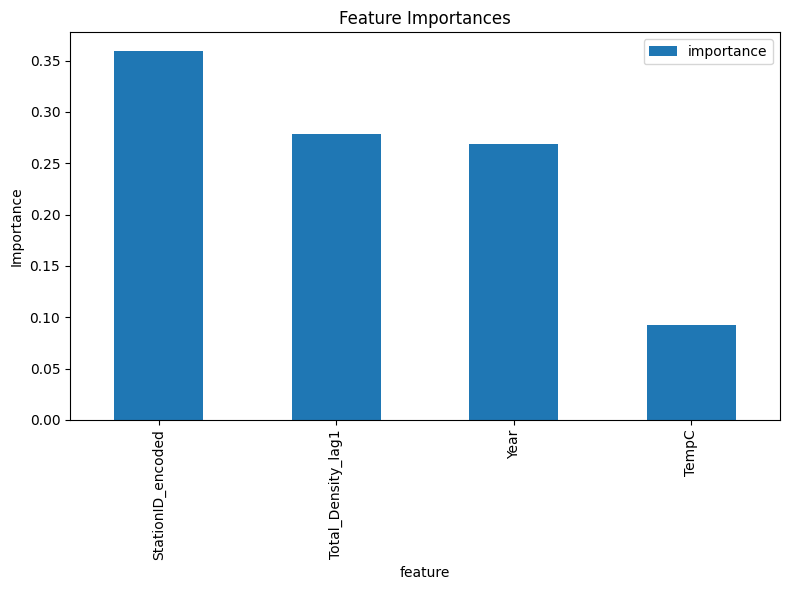

prediction part ...
RMSE: 0.31432066076186055
MSE: 0.09879747778177261
MAE Absolute Error: 0.21179898083209991
R² Score: 0.9888809323310852
Pcover_Total
training the model ...
Model training is complete.
Feature Importances:
                 feature  importance
0                   Year    0.997370
3      StationID_encoded    0.002627
4                  TempC    0.000001
2     Total_Density_lag1    0.000001
1  Species_Richness_lag1    0.000001


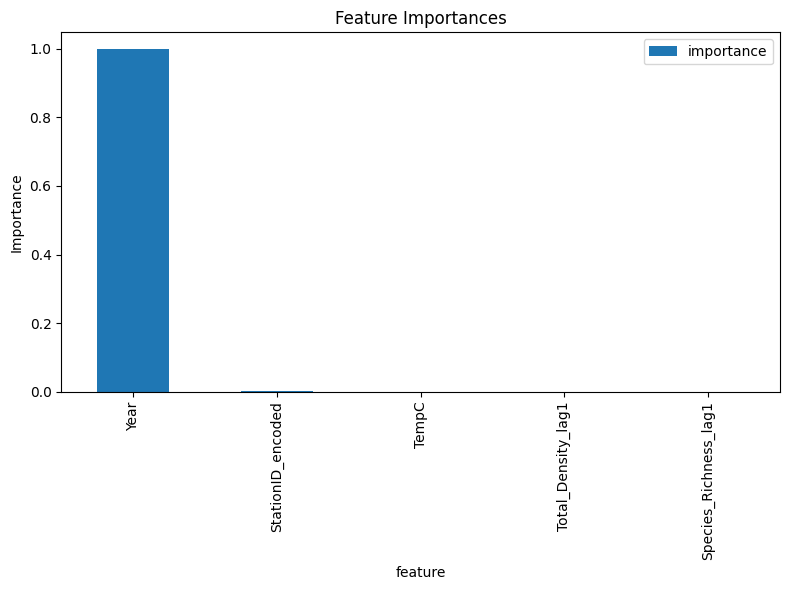

prediction part ...
RMSE: 0.338413445003042
MSE: 0.11452365975882693
MAE Absolute Error: 0.21724707181200617
R² Score: 0.9999996728061106


In [ ]:
black = '\033[30m'
red = '\033[31m'
green = '\033[32m'
yellow = '\033[33m'
blue = '\033[34m'
magenta = '\033[35m'
cyan = '\033[36m'
white = '\033[37m'
orange = "\033[38;5;208m"
bold = '\033[1m'
reset = '\033[0m'

# ---------------------load the data --------------------
# scor = pd.read_csv('scor_minimal.csv')
# path = "dataset/"
# temp = pd.read_csv(path+'CREMP_Temperatures_2023.csv')
# con = [col for col in scor.columns if 'SCOR_ConditionCounts' in col]
# pc = [col for col in scor.columns if 'Pcover_StonyCoralSpecies' in col]
# duplicate = [col for col in scor.columns if '.1' in col]
# scor.drop(columns=pc+con+duplicate, inplace=True)
# ---------------------lagged feature--------------------

for lag in [1, 2]:
    for col in ['TempC', 'Stations_Depth_ft', 'SCOR_RawData_LTA_cm2','healthy', 'Health_Score' ,'Species_Richness', 'Total_Density' ,
                'Total_Mortality_Percent',  'Pcover_Total', 'SCOR_RawData_Diameter_cm', 'SCOR_RawData_Height_cm' ]:
        scor[f"{col}_lag{lag}"] = scor[col].shift(lag)

# ---------------------station label encoding--------------------

le = LabelEncoder()
scor['StationID_encoded'] = le.fit_transform(scor['StationID'])

# ---------------------date as index--------------------

# scor.set_index('Date', inplace=True)

# ---------------------run the models--------------------
features = {
          "Total_Density" : [ 'Total_Density','Total_Density_lag1','StationID_encoded', 'TempC' , ],
          "Species_Richness":['Year', 'Total_Density_lag1',
                              # 'Species_Richness_lag1',
                              'Species_Richness', 'StationID_encoded', 'TempC' , ],
          "Pcover_Total":[ 'Year', 'Species_Richness_lag1', 'Total_Density_lag1',"Pcover_Total",'StationID_encoded', 'TempC' , ]
           }
cat_model_Total_Density, X_test, y_test , y_pred = model_pipeline(model_type="catboost",
                                                      df=scor[features["Total_Density"]],
                                                      cross_val=False,
                                                      grid_search=False,
                                                      transform=True,
                                                      target ="Total_Density" )

cat_model_Species_Richness, X_test, y_test , y_pred = model_pipeline(model_type="catboost",
                                                        df=scor[features["Species_Richness"]],
                                                        cross_val=False,
                                                        grid_search=False,
                                                        transform=True,
                                                        target ="Species_Richness" )

cat_model_Pcover_Total, X_test, y_test , y_pred = model_pipeline(model_type="catboost",
                                                        df=scor[features["Pcover_Total"]],
                                                        cross_val=False,
                                                        grid_search=False,
                                                        transform=True,
                                                        target ="Pcover_Total" )

xgb_model_Total_Density, X_test, y_test , y_pred = model_pipeline(model_type="xgboost",
                                                      df=scor[features["Total_Density"]],
                                                      cross_val=False,
                                                      grid_search=False,
                                                      transform=True,
                                                      target ="Total_Density" )

xgb_model_Species_Richness, X_test, y_test , y_pred = model_pipeline(model_type="xgboost",
                                                        df=scor[features["Species_Richness"]],
                                                        cross_val=False,
                                                        grid_search=False,
                                                        transform=True,
                                                        target ="Species_Richness" )

xgb_model_Pcover_Total, X_test, y_test , y_pred = model_pipeline(model_type="xgboost",
                                                        df=scor[features["Pcover_Total"]],
                                                        cross_val=False,
                                                        grid_search=False,
                                                        transform=True,
                                                        target ="Pcover_Total" )

##### Total_pipeline

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Train RMSE: 0.0059
Train MAE: 0.0047

Test RMSE: 2.8565
Test MAE: 2.8565

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


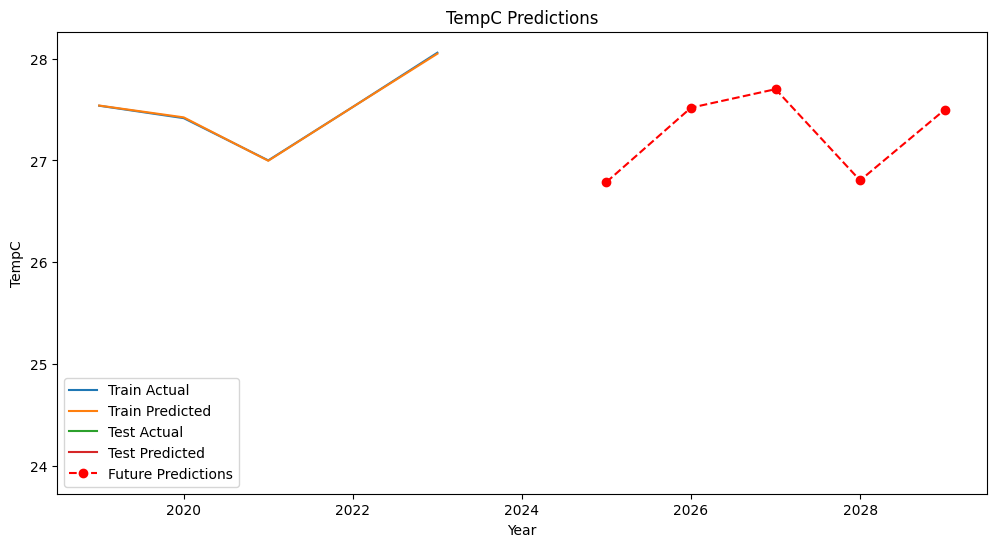


Future Predictions of TempC:
2025: 26.79
2026: 27.52
2027: 27.70
2028: 26.80
2029: 27.50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Train RMSE: 0.1024
Train MAE: 0.0665

Test RMSE: 2.1940
Test MAE: 1.9065

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


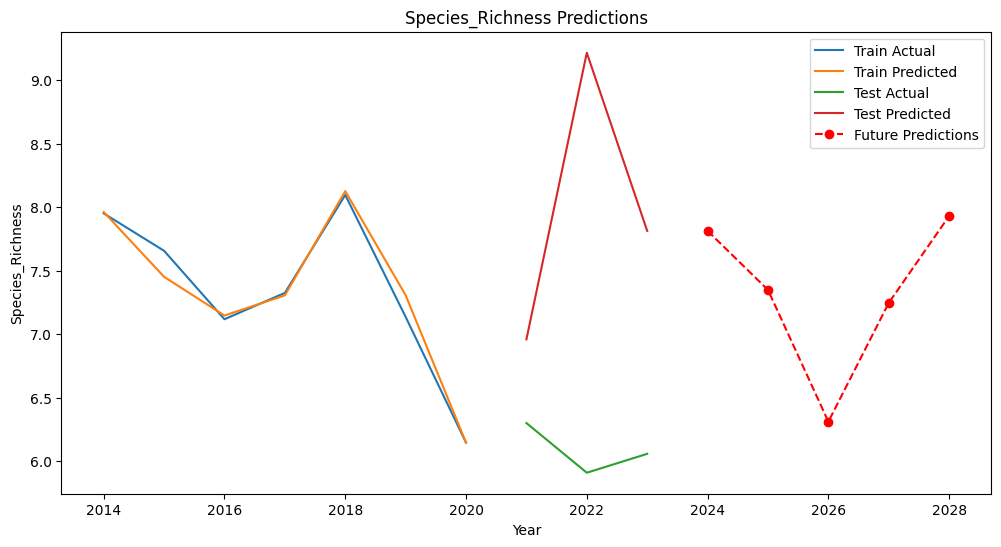


Future Predictions of Species_Richness:
2024: 7.81
2025: 7.35
2026: 6.31
2027: 7.25
2028: 7.93
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Train RMSE: 0.0338
Train MAE: 0.0288

Test RMSE: 0.4874
Test MAE: 0.3550

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


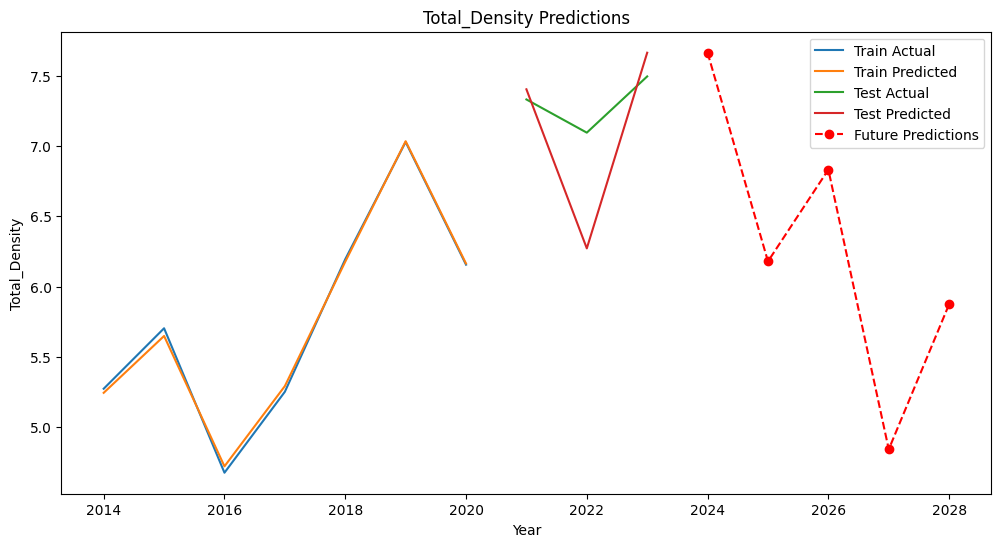


Future Predictions of Total_Density:
2024: 7.67
2025: 6.18
2026: 6.83
2027: 4.84
2028: 5.87
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Train RMSE: 7.8064
Train MAE: 7.5962

Test RMSE: 76.8848
Test MAE: 68.0411

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


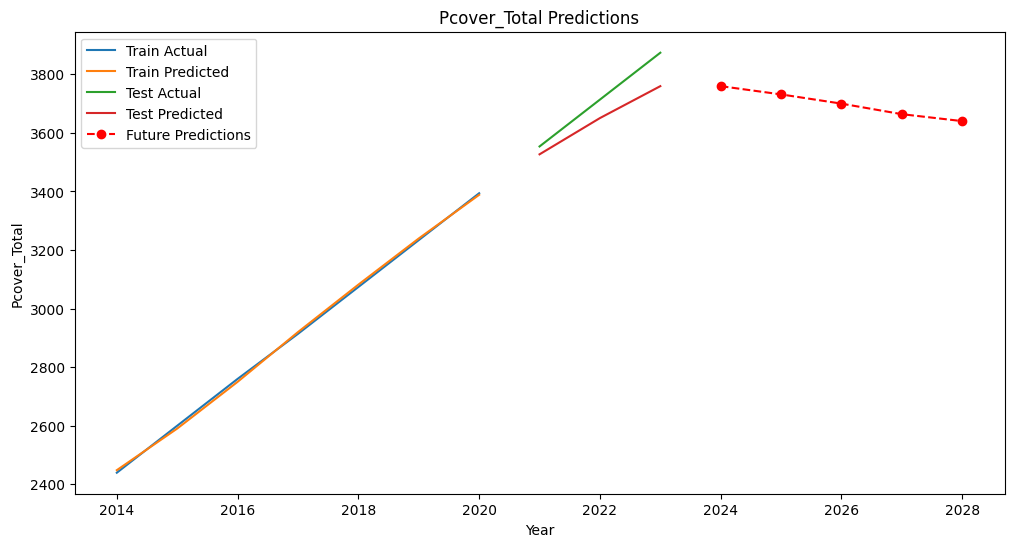


Future Predictions of Pcover_Total:
2024: 3759.34
2025: 3731.14
2026: 3699.64
2027: 3663.63
2028: 3639.96
Predicted values for station :613
{'Pcover_Total': [np.float64(3837.5400773080737), np.float64(3837.5400773080737), np.float64(3837.5400773080737), np.float64(3837.5400773080737), np.float64(3837.5400773080737)], 'Total_Density': [np.float64(6.839533197288368), np.float64(6.839533197288368), np.float64(6.839533197288368), np.float64(6.839533197288368), np.float64(6.839533197288368)], 'Species_Richness': [np.float64(7.294458546876841), np.float64(7.294458546876841), np.float64(7.294458546876841), np.float64(7.294458546876841), np.float64(7.294458546876841)]}


In [ ]:

"""
order of forecasting :
1-total density ==> features: ['Total_Density_lag1','StationID_encoded' ,'TempC' , ]
2-species richness ==> features: ['Year','Total_Density_lag1', 'StationID_encoded' ,'TempC' , ]
3-Pcover ==> features:  [ 'Year', 'Species_Richness_lag1', 'Total_Density_lag1','StationID_encoded','TempC' , ]
"""

def Total_pipeline(StationID):
  StationID_encoded = int(scor[scor['StationID']== StationID]['StationID_encoded'][0])
  year = 2023
  predicted = {
       "Total_Density" : [float(scor[(scor['Year'] == year) & (scor['StationID'] == StationID)]['Total_Density'][0])],
        "Species_Richness":[float(scor[(scor['Year'] == year) & (scor['StationID'] == StationID)]['Species_Richness'][0])],
        "Pcover_Total":[float(scor[(scor['Year'] == year) & (scor['StationID'] == StationID)]['Pcover_Total'][0])],
        "TempC":[float(scor[(scor['Year'] == year) & (scor['StationID'] == StationID)]['TempC'][0] )]
  }

  SiteID = int(scor[scor['StationID']== StationID]['SiteID'][0])
  future_temp = lstm_forecast(SiteID , temp, 'TempC')
  future_species_richness = lstm_forecast(SiteID , scor[['Species_Richness', 'Year', 'SiteID']], 'Species_Richness')
  future_Total_Density = lstm_forecast(SiteID , scor[['Total_Density', 'Year', 'SiteID']], 'Total_Density')
  future_Pcover_Total = lstm_forecast(SiteID ,scor[['Pcover_Total', 'Year', 'SiteID']], 'Pcover_Total')

  def forecast ( target, features, model):
      y_pred = model.predict([features])
      return float(y_pred[0])

  for step in range(5):

    if year ==2024:
      SiteID = int(scor[scor['StationID']== StationID]['SiteID'][0])
      # print(f'SiteID {SiteID} {StationID}')
      grouped_data = temp.groupby(['SiteID', 'Year'])['TempC'].mean()
      grouped_data = grouped_data.reset_index()
      data = grouped_data[grouped_data['SiteID'] == SiteID]
      # print(data[(data['Year'] == year) & (data['SiteID'] == SiteID)]['TempC'])
      if(len(data[(data['Year'] == year) & (data['SiteID'] == SiteID)]['TempC'])):
        predicted['TempC'].append(float(data[(data['Year'] == year) & (data['SiteID'] == SiteID)]['TempC']))
      else:
        raise Exception( f'the data for this Station {StationID} doese not have temprerature')

    elif year==2025 :
      for y, t in future_temp.items():
        if y>2024:
          predicted['TempC'].append(t)



    # Total_Density
    # features: ['Total_Density_lag1','StationID_encoded' ,'TempC' , ]
    features = [
                predicted["Total_Density"][step],
                StationID_encoded,
                predicted["TempC"][step],
                ]
    Total_Density1 = forecast('Total_Density', features, cat_model_Total_Density)
    Total_Density2 = forecast('Total_Density', features, xgb_model_Total_Density)
    mean_Total_Density = (Total_Density2+Total_Density1) / 2
    predicted['Total_Density'].append(mean_Total_Density)

    # Species_Richness
    # features: ['Year','Total_Density_lag1', 'StationID_encoded', 'TempC']
    features = [year,
                predicted["Total_Density"][step],
                # predicted["Species_Richness"][step],
                StationID_encoded,
                predicted["TempC"][step],
                ]
    Species_Richness1 = forecast('Species_Richness', features, cat_model_Species_Richness)
    Species_Richness2 = forecast('Species_Richness', features, xgb_model_Species_Richness)
    mean_Species_Richness = (Species_Richness2 + Species_Richness1) / 2
    predicted['Species_Richness'].append(mean_Species_Richness)

    # Pcover_Total
    # features:[ 'Year', 'Species_Richness_lag1', 'Total_Density_lag1','StationID_encoded','TempC']
    features = [year,
                predicted["Species_Richness"][step],
                predicted["Total_Density"][step],
                StationID_encoded,
                predicted["TempC"][step],

                ]
    Pcover_Total1 = forecast('Pcover_Total', features, cat_model_Pcover_Total)
    Pcover_Total2 = forecast('Pcover_Total', features, xgb_model_Pcover_Total)
    mean_Pcover_Total = (Pcover_Total2 + Pcover_Total1) / 2
    predicted['Pcover_Total'].append(mean_Pcover_Total)

    year+=1
  final ={'Pcover_Total':[],
          'Total_Density':[],
          'Species_Richness':[],
          }
  for i in range(len(predicted['Pcover_Total'])):
    year = 2024
    if i>0:
      final['Pcover_Total'].append(( predicted['Pcover_Total'][i] + future_Pcover_Total[year]) / 2)
      final['Total_Density'].append(( predicted['Total_Density'][i] + future_Total_Density[year]) / 2)
      final['Species_Richness'].append( ( predicted['Species_Richness'][i] + future_species_richness[year]) / 2)
      year += 1


  print (f'{yellow}Predicted values for station :{StationID}{reset}')

  return final , future_Pcover_Total , future_Total_Density , future_species_richness


predicted , future_Pcover_Total , future_Total_Density , future_species_richness = Total_pipeline(StationID=613)
predicted

In [ ]:
predicted

{'Pcover_Total': [np.float64(3837.5400773080737),
  np.float64(3837.5400773080737),
  np.float64(3837.5400773080737),
  np.float64(3837.5400773080737),
  np.float64(3837.5400773080737)],
 'Total_Density': [np.float64(6.839533197288368),
  np.float64(6.839533197288368),
  np.float64(6.839533197288368),
  np.float64(6.839533197288368),
  np.float64(6.839533197288368)],
 'Species_Richness': [np.float64(7.294458546876841),
  np.float64(7.294458546876841),
  np.float64(7.294458546876841),
  np.float64(7.294458546876841),
  np.float64(7.294458546876841)]}

In [ ]:
scor['StationID'].unique()

array([181, 343, 342, 344, 341, 573, 574, 572, 354, 561, 562, 554, 563,
       552, 553, 551, 571, 564, 353, 351, 352, 251, 252, 771, 764, 772,
       761, 754, 763, 762, 232, 231, 242, 241, 752, 753, 751, 773, 774,
       184, 182, 183, 513, 512, 511, 504, 514, 503, 701, 501, 502, 523,
       524, 531, 544, 532, 534, 541, 533, 543, 542, 521, 522, 733, 734,
       724, 744, 743, 741, 742, 732, 731, 703, 702, 723, 722, 721, 704,
       321, 304, 222, 212, 221, 211, 301, 302, 303, 324, 323, 333, 332,
       331, 334, 322, 364, 363, 614, 361, 613, 611, 604, 612, 362, 374,
       262, 801, 802, 803, 784, 791, 793, 794, 792, 812, 813, 814, 804,
       811, 261, 782, 781, 783, 383, 384, 391, 392, 393, 381, 382, 581,
       583, 582, 584, 371, 594, 593, 603, 601, 602, 591, 592, 373, 394,
       402, 403, 401, 404, 372, 214, 213, 223, 224, 253, 244, 243, 254,
       234, 233, 263, 264])

###### Total_Density

training the model ...
Model training is complete.
Feature Importances:
              feature  importance
0  Total_Density_lag1    0.999617
1   StationID_encoded    0.000383


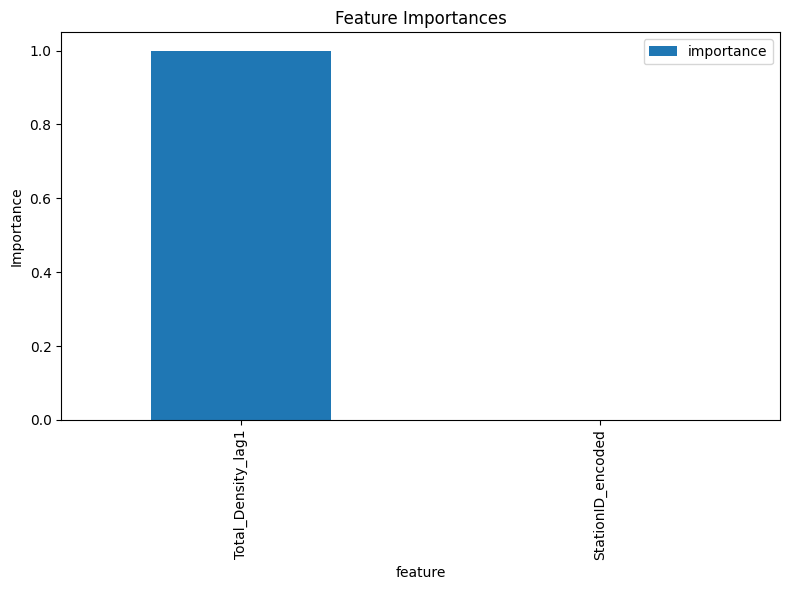

prediction part ...
RMSE: 0.08992109521757025
MSE: 0.008085803365127335
MAE Absolute Error: 0.004860920662482827
R² Score: 0.9997005830044711


In [ ]:
# target lag
features = [ 'Total_Density','Total_Density_lag1','StationID_encoded']
xgb_model, X_test, y_test , y_pred = model_pipeline(model_type="xgboost",
                                                        df=scor[features],
                                                        cross_val=False,
                                                        grid_search=False,
                                                        transform=True,
                                                        target ="Total_Density" )

# recursive


###### Species_Richness

training the model ...
Model training is complete.
Feature Importances:
              feature  importance
2   StationID_encoded    0.416812
1  Total_Density_lag1    0.340451
0                Year    0.242737


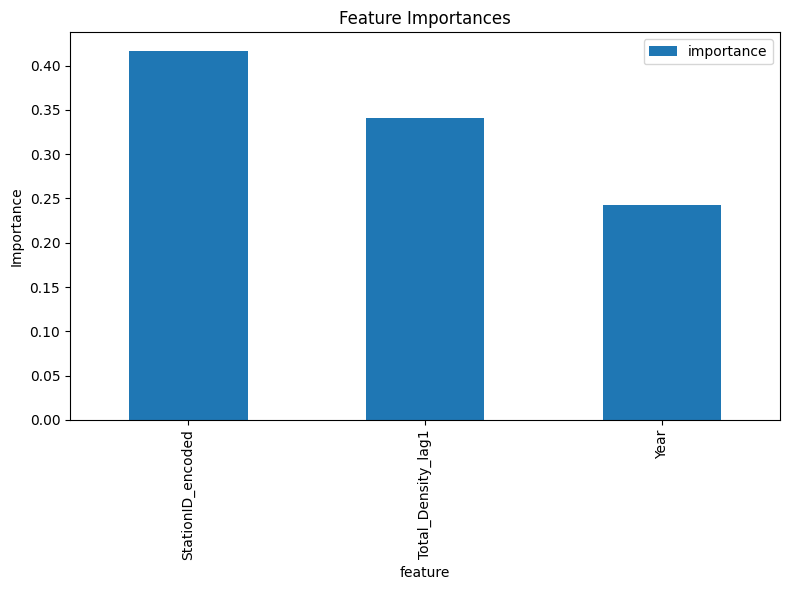

prediction part ...
RMSE: 0.33980321094276766
MSE: 0.11546622216701508
MAE Absolute Error: 0.23436984419822693
R² Score: 0.9870049357414246


In [ ]:
# without target lag
# features = ['Year', 'Total_Density_lag1', 'Species_Richness_lag1', 'Species_Richness']
features = ['Year', 'Total_Density_lag1',  'Species_Richness','StationID_encoded']
xgb_model, X_test, y_test , y_pred = model_pipeline(model_type="xgboost",
                                                        df=scor[features],
                                                        cross_val=False,
                                                        grid_search=False,
                                                        transform=True,
                                                        target ="Species_Richness" )

# recursive


training the model ...
Model training is complete.
Feature Importances:
                 feature  importance
2  Species_Richness_lag1    0.999509
3      StationID_encoded    0.000230
1     Total_Density_lag1    0.000185
0                   Year    0.000076


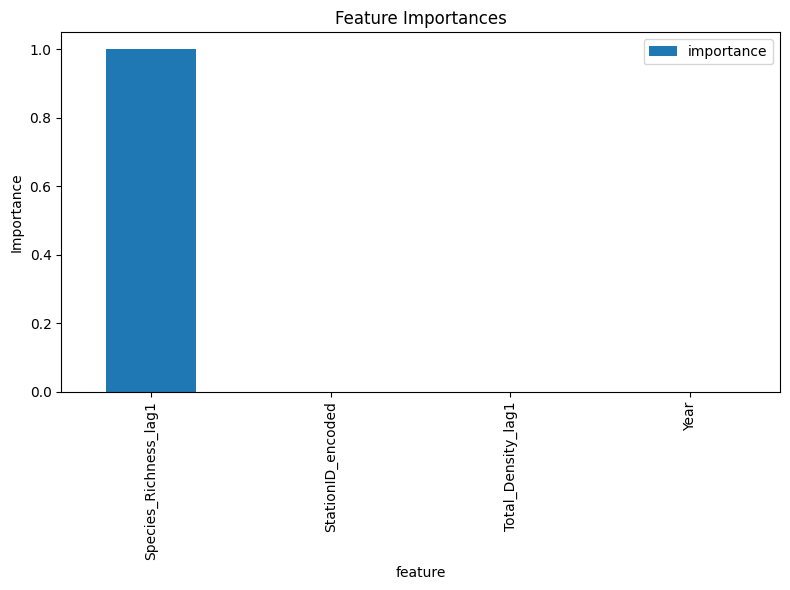

prediction part ...
RMSE: 0.08574551573704473
MSE: 0.007352293469011784
MAE Absolute Error: 0.0043960451148450375
R² Score: 0.999172568321228


In [ ]:
#  target lag
features = ['Year', 'Total_Density_lag1', 'Species_Richness_lag1', 'Species_Richness', 'StationID_encoded']

xgb_model, X_test, y_test , y_pred = model_pipeline(model_type="xgboost",
                                                        df=scor[features],
                                                        cross_val=False,
                                                        grid_search=False,
                                                        transform=True,
                                                        target ="Species_Richness" )

# recursive


training the model ...
Model training is complete.
Feature Importances:
              feature  importance
3   StationID_encoded   39.570285
1  Total_Density_lag1   22.851266
0                Year   19.657564
2    Stony_coral_lag1   17.920885


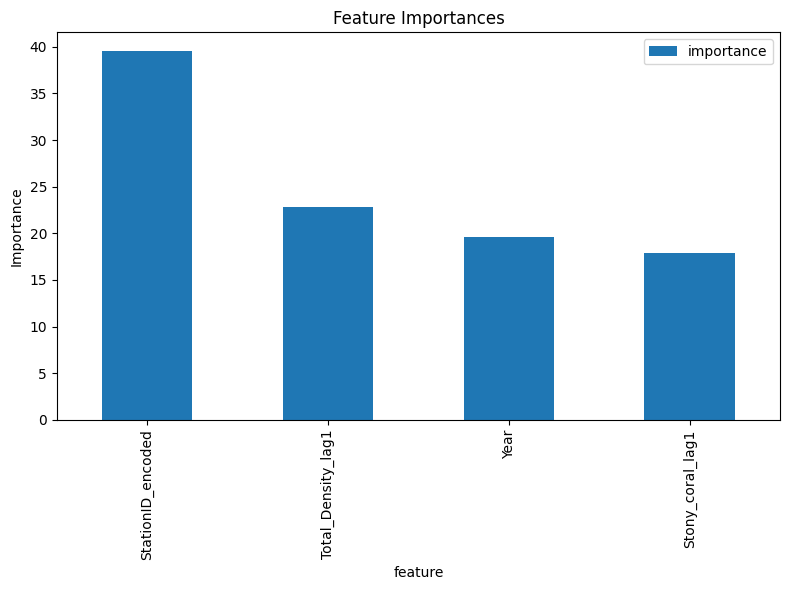

prediction part ...
Number of NaN values in predictions before dropping: 0
Number of NaN values in predictions after dropping: 0
len test: 248386
Mean Squared Error: 0.12439997193599002
Mean Absolute Error: 0.24498389939607462
R² Score: 0.985999505248656


In [ ]:
#  without target lag
# features = ['Year', 'Total_Density_lag1', 'Stony_coral_lag1', 'Species_Richness_lag1', 'Species_Richness']
features = ['Year', 'Total_Density_lag1', 'Stony_coral_lag1',  'Species_Richness','StationID_encoded']
catboost_model, X_test, y_test , y_pred = model_pipeline(model_type="catboost",
                                                        df=scor[features],
                                                        cross_val=False,
                                                        grid_search=False,
                                                        transform=True,
                                                        target ="Species_Richness" )

# recursive


training the model ...
Model training is complete.
Feature Importances:
                 feature  importance
3  Species_Richness_lag1   99.514205
4      StationID_encoded    0.377807
1     Total_Density_lag1    0.045586
2       Stony_coral_lag1    0.043353
0                   Year    0.019050


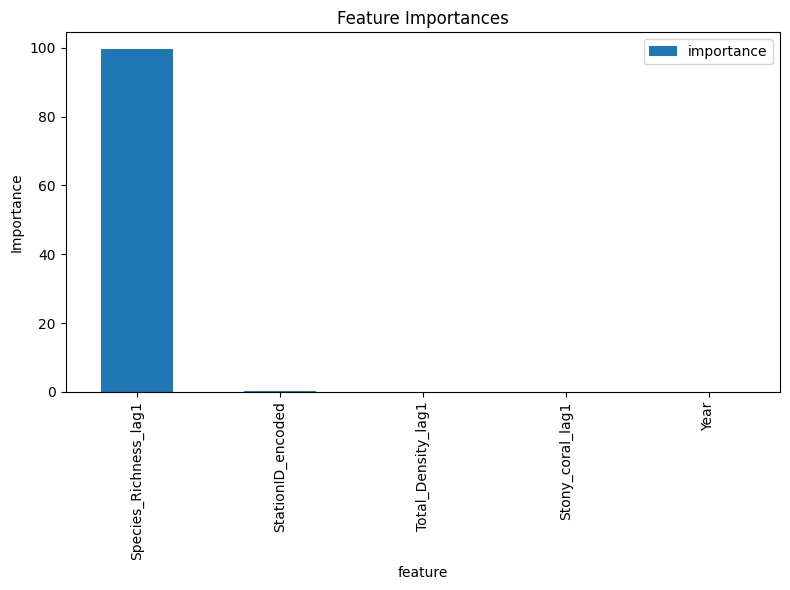

prediction part ...
Number of NaN values in predictions before dropping: 0
Number of NaN values in predictions after dropping: 0
len test: 248386
Mean Squared Error: 0.00762252654620512
Mean Absolute Error: 0.004810497115094062
R² Score: 0.9991421288828181


In [ ]:
#  target lag
features = ['Year', 'Total_Density_lag1', 'Stony_coral_lag1', 'Species_Richness_lag1', 'Species_Richness','StationID_encoded']
# features = ['Year', 'Total_Density_lag1', 'Stony_coral_lag1',  'Species_Richness']
catboost_model, X_test, y_test , y_pred = model_pipeline(model_type="catboost",
                                                        df=scor[features],
                                                        cross_val=False,
                                                        grid_search=False,
                                                        transform=True,
                                                        target ="Species_Richness" )

# recursive


###### Pcover_total

training the model ...
Model training is complete.
Feature Importances:
                 feature  importance
3      StationID_encoded    0.776692
2     Total_Density_lag1    0.114315
0                   Year    0.066788
1  Species_Richness_lag1    0.042205


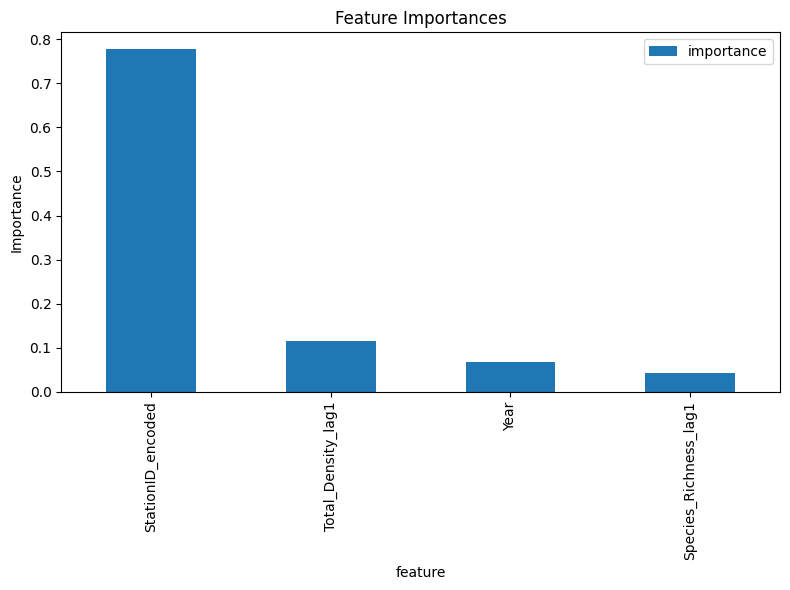

prediction part ...
RMSE: 0.007074611749955391
MSE: 5.0050131412606874e-05
MAE Absolute Error: 0.004804481118918501
R² Score: 0.9981221286156825


In [ ]:
# without target lag

features = [ 'Year', 'Species_Richness_lag1', 'Total_Density_lag1',"Pcover_Total",'StationID_encoded']

xgb_model, X_test, y_test , y_pred = model_pipeline(model_type="xgboost",
                                                        df=scor[features],
                                                        cross_val=False,
                                                        grid_search=False,
                                                        transform=True,
                                                        target ="Pcover_Total" )

# recursive


training the model ...
Model training is complete.
Feature Importances:
                 feature  importance
3      Pcover_Total_lag1    0.998115
2     Total_Density_lag1    0.000800
0                   Year    0.000517
4      StationID_encoded    0.000284
1  Species_Richness_lag1    0.000283


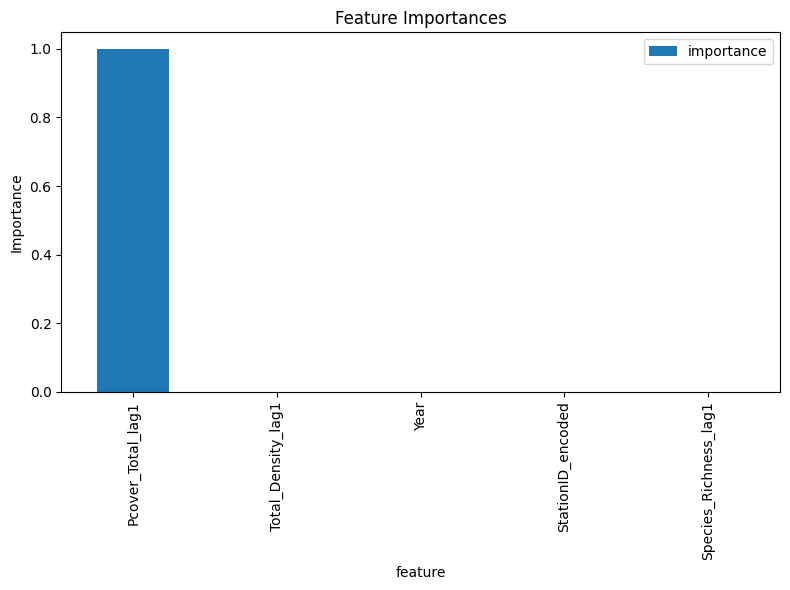

prediction part ...
RMSE: 0.002714051662339839
MSE: 7.3660764258496435e-06
MAE Absolute Error: 0.0002921480570805079
R² Score: 0.9997236262174666


In [ ]:
# target lag

features = [ 'Year', 'Species_Richness_lag1', 'Total_Density_lag1',"Pcover_Total","Pcover_Total_lag1", 'StationID_encoded']

xgb_model, X_test, y_test , y_pred = model_pipeline(model_type="xgboost",
                                                        df=scor[features],
                                                        cross_val=False,
                                                        grid_search=False,
                                                        transform=True,
                                                        target ="Pcover_Total" )

# recursive


training the model ...


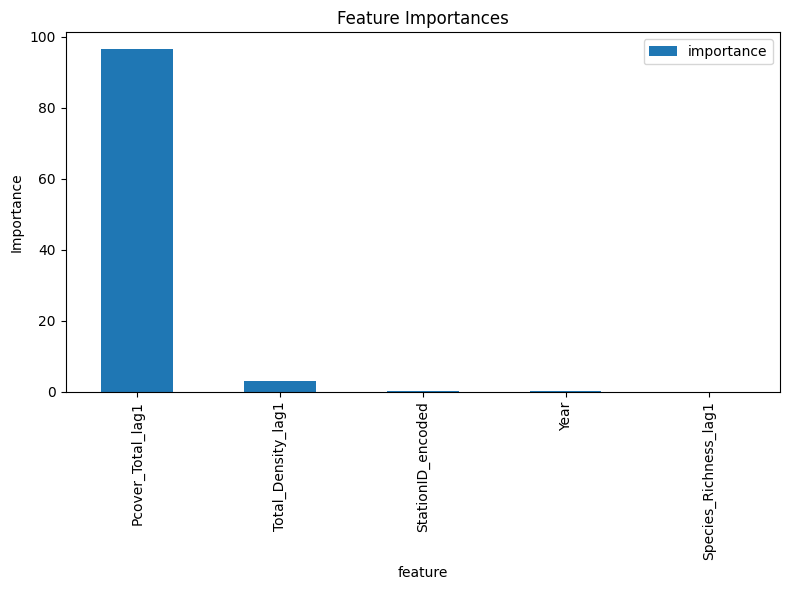

prediction part ...
RMSE: 0.0027458360763175844
MSE: 7.539615758007147e-06
MAE Absolute Error: 0.0005168843363977695
R² Score: 0.999717115054824


In [ ]:
# target lag
features = [ 'Year', 'Species_Richness_lag1', 'Total_Density_lag1',"Pcover_Total","Pcover_Total_lag1", 'StationID_encoded']

catboost_model, X_test, y_test , y_pred = model_pipeline(model_type="catboost",
                                                        df=scor[features],
                                                        cross_val=False,
                                                        grid_search=False,
                                                        transform=True,
                                                        target ="Pcover_Total" )

# recursive


training the model ...
Model training is complete.
Feature Importances:
                 feature  importance
3      StationID_encoded   73.731551
2     Total_Density_lag1   12.533930
0                   Year    7.917007
1  Species_Richness_lag1    5.817511


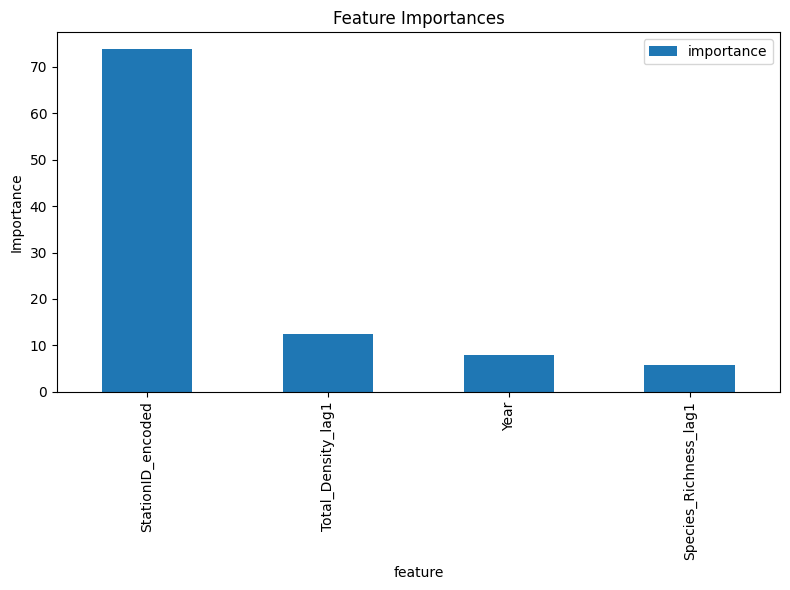

prediction part ...
RMSE: 0.009237868448330508
MSE: 8.533821346866031e-05
MAE Absolute Error: 0.006501451037286361
R² Score: 0.9967981265075918


In [ ]:
#without target lag
features = [ 'Year', 'Species_Richness_lag1', 'Total_Density_lag1',"Pcover_Total", 'StationID_encoded']

catboost_model, X_test, y_test , y_pred = model_pipeline(model_type="catboost",
                                                        df=scor[features],
                                                        cross_val=False,
                                                        grid_search=False,
                                                        transform=True,
                                                        target ="Pcover_Total" )

# recursive
